In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
prevSampled=0
nSamples=36
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [6]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    if epoch%10==0:
        print(' Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all







In [8]:
name_train='conditionClf_origImg_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
18
cd16
4555


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1531 loss_val: 1.1639 time: 5.3383s
 Epoch: 0010 loss_train: 0.0164 loss_val: 1.8097 time: 3.3741s
 Epoch: 0020 loss_train: 0.0040 loss_val: 1.8920 time: 3.7587s
 Epoch: 0030 loss_train: 0.0025 loss_val: 1.9723 time: 3.4154s
 Epoch: 0040 loss_train: 0.0103 loss_val: 2.0812 time: 3.6550s
 Epoch: 0050 loss_train: 0.0034 loss_val: 2.0561 time: 3.3977s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.0981 time: 3.5652s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.1503 time: 3.5656s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1898 time: 3.3712s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2228 time: 4.7695s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2517 time: 4.5403s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2781 time: 4.0678s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3021 time: 5.1466s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3248 time: 5.7620s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3463 time: 6.3908s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3669 time: 

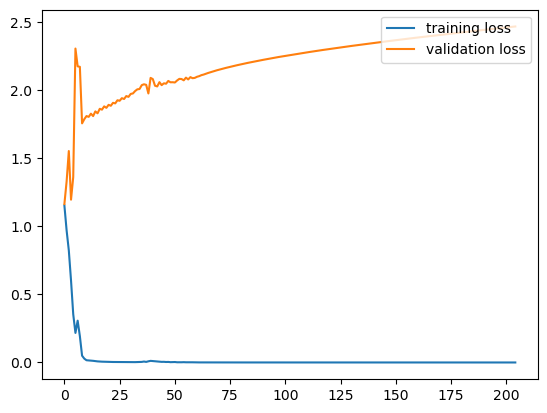

cd3
3760


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9870 loss_val: 1.2100 time: 6.6242s
 Epoch: 0010 loss_train: 0.0025 loss_val: 1.1242 time: 5.6368s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.1728 time: 6.2439s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2075 time: 6.5151s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2351 time: 6.1902s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2583 time: 6.1915s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2783 time: 4.9290s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2963 time: 6.4320s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3126 time: 6.6018s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3278 time: 5.5496s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3418 time: 6.3662s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3552 time: 6.2411s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3677 time: 6.4866s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3797 time: 5.8311s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3914 time: 5.4932s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4026 time: 

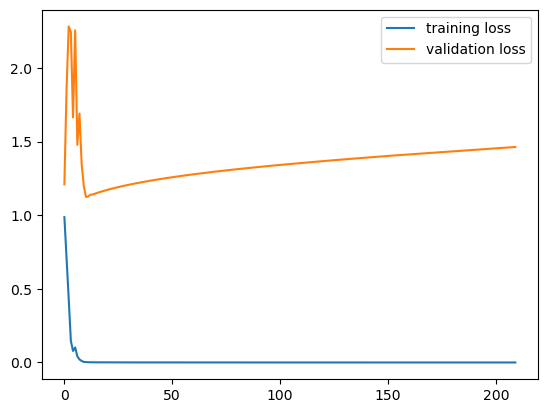

cd4
5580


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1555 loss_val: 11.5428 time: 7.2912s
 Epoch: 0010 loss_train: 0.0355 loss_val: 2.0513 time: 8.8239s
 Epoch: 0020 loss_train: 0.0035 loss_val: 1.9200 time: 8.7210s
 Epoch: 0030 loss_train: 0.0014 loss_val: 1.9825 time: 8.7114s
 Epoch: 0040 loss_train: 0.0012 loss_val: 2.0332 time: 9.1398s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.0817 time: 9.5915s
 Epoch: 0060 loss_train: 0.0035 loss_val: 2.1134 time: 8.5334s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.2092 time: 8.6462s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.2043 time: 7.5270s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.2430 time: 7.9447s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.2741 time: 8.9889s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.3040 time: 8.7839s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.3220 time: 9.6905s
 Epoch: 0130 loss_train: 0.2808 loss_val: 2.0832 time: 8.7117s
 Epoch: 0140 loss_train: 0.0017 loss_val: 2.3320 time: 8.5029s
 Epoch: 0150 loss_train: 0.0016 loss_val: 2.4133 time:

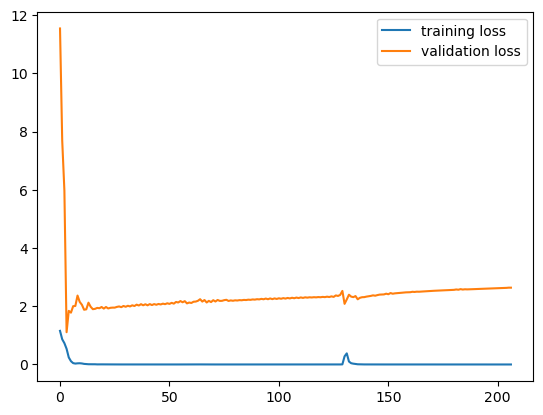

cd8
5604


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0136 loss_val: 37.1033 time: 8.1628s
 Epoch: 0010 loss_train: 0.0334 loss_val: 1.8466 time: 8.6709s
 Epoch: 0020 loss_train: 0.0023 loss_val: 1.7754 time: 8.7579s
 Epoch: 0030 loss_train: 0.0016 loss_val: 1.8452 time: 9.0920s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.8977 time: 8.5564s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.9406 time: 7.6297s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.9761 time: 9.1033s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.0073 time: 8.6378s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.0354 time: 9.2402s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0614 time: 8.2011s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0856 time: 10.3822s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1085 time: 7.6126s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.1305 time: 9.2501s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.1514 time: 8.4460s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.1717 time: 8.2911s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.1914 time

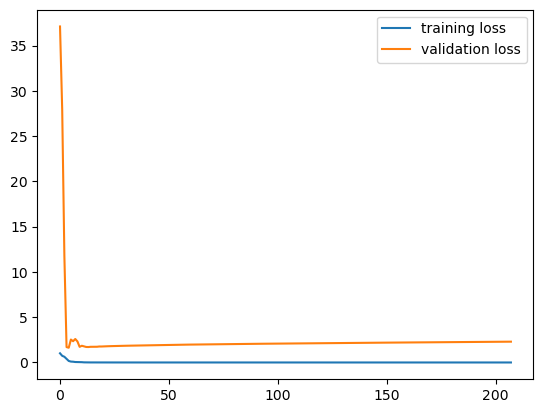

gh2ax
4837


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9938 loss_val: 3.6396 time: 5.6139s
 Epoch: 0010 loss_train: 0.0027 loss_val: 0.5949 time: 6.3750s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.6179 time: 6.9286s
 Epoch: 0030 loss_train: 0.0004 loss_val: 0.6412 time: 5.9352s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.6595 time: 5.4473s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.6750 time: 6.3159s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.6883 time: 6.3668s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7002 time: 7.2160s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.7109 time: 5.3335s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.7208 time: 8.0811s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.7301 time: 5.1294s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.7389 time: 7.5697s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.7472 time: 6.5250s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.7552 time: 7.4818s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.7629 time: 7.1781s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.7703 time: 

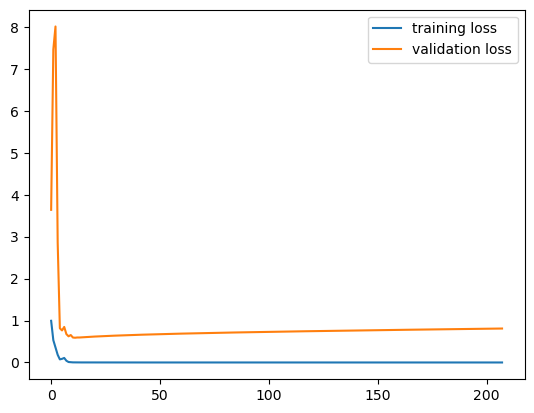

lamin
4838


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.8996 loss_val: 29.7419 time: 7.2505s
 Epoch: 0010 loss_train: 0.0033 loss_val: 1.0985 time: 6.2885s
 Epoch: 0020 loss_train: 0.0017 loss_val: 1.2057 time: 6.1825s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.2530 time: 6.3240s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.2823 time: 6.9688s
 Epoch: 0050 loss_train: 0.0001 loss_val: 1.3061 time: 7.4808s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.3271 time: 6.7653s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3457 time: 7.1296s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3628 time: 5.9885s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3786 time: 8.3154s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3934 time: 7.1709s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.4075 time: 7.6891s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.4210 time: 7.2597s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.4339 time: 6.6174s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4464 time: 7.3920s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4585 time:

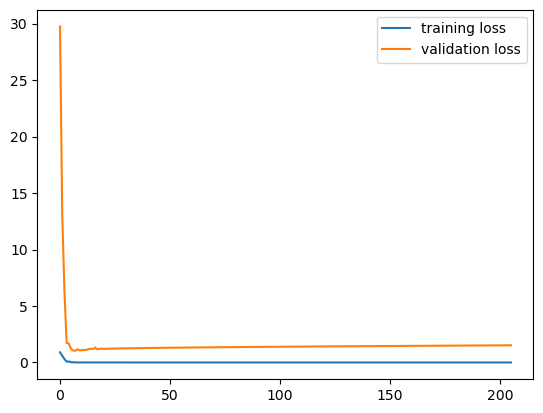

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
cd16
4490


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1248 loss_val: 1.6063 time: 7.7445s
 Epoch: 0010 loss_train: 0.0083 loss_val: 1.9086 time: 7.1780s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.9002 time: 7.6574s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.9539 time: 8.4387s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.9968 time: 7.2748s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0336 time: 9.2729s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.0656 time: 7.2208s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0943 time: 7.8032s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.1207 time: 7.8577s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1451 time: 7.6524s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1679 time: 7.3610s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1898 time: 6.6628s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2104 time: 6.8432s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2302 time: 8.2854s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2492 time: 7.9953s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2676 time: 

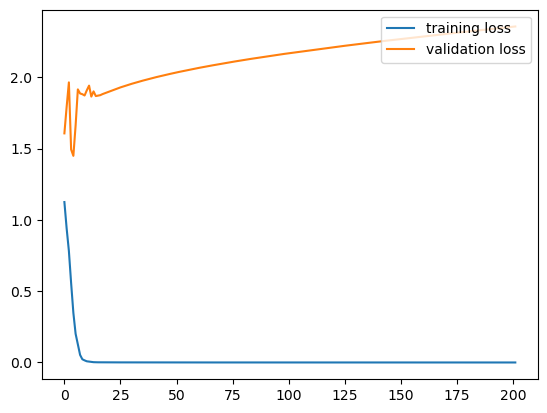

cd3
3802


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9435 loss_val: 1.5063 time: 6.8504s
 Epoch: 0010 loss_train: 0.0025 loss_val: 0.9957 time: 6.4784s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.0368 time: 6.5971s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.0737 time: 6.0469s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1023 time: 6.1249s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1259 time: 7.3997s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1462 time: 6.2680s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.1640 time: 6.4166s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1802 time: 6.0721s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1949 time: 7.8386s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2086 time: 6.4484s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2215 time: 5.9629s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2336 time: 5.3859s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.2452 time: 6.1125s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.2564 time: 5.1056s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.2671 time: 

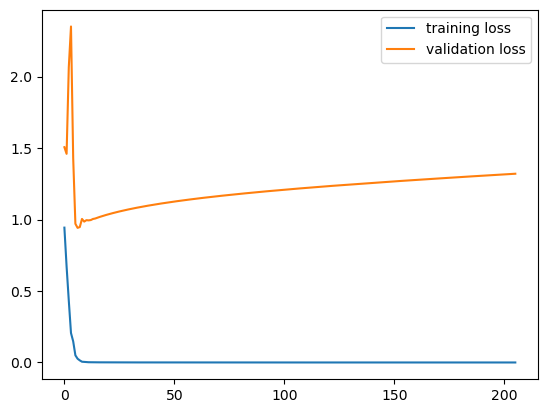

cd4
5518


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1382 loss_val: 14.1692 time: 10.4960s
 Epoch: 0010 loss_train: 0.0148 loss_val: 1.9105 time: 7.6104s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.9587 time: 8.0362s
 Epoch: 0030 loss_train: 0.0004 loss_val: 2.0150 time: 8.6158s
 Epoch: 0040 loss_train: 0.0003 loss_val: 2.0581 time: 9.0882s
 Epoch: 0050 loss_train: 0.0002 loss_val: 2.0940 time: 9.0516s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.1258 time: 8.8483s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.1543 time: 7.8382s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.1804 time: 9.4649s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2048 time: 8.0223s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2276 time: 9.3342s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2494 time: 7.9779s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.2703 time: 9.8743s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.2905 time: 6.7410s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.3101 time: 9.1107s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.3292 time

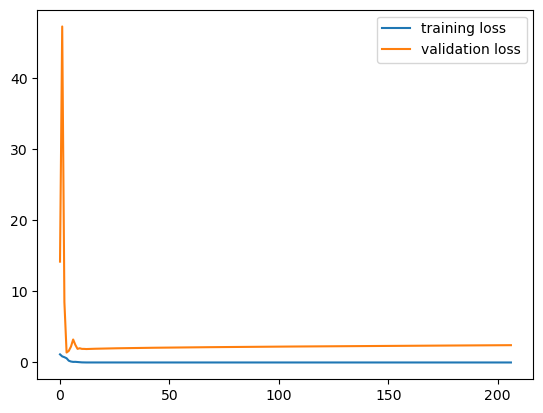

cd8
5545


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9696 loss_val: 51.9080 time: 8.7113s
 Epoch: 0010 loss_train: 0.0015 loss_val: 1.6739 time: 7.1422s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.7682 time: 9.7190s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.8316 time: 8.6518s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.8803 time: 7.5765s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.9205 time: 6.0440s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.9553 time: 9.0469s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.9860 time: 8.4745s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.0139 time: 8.2121s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0399 time: 7.2032s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0643 time: 9.1048s
 Epoch: 0110 loss_train: 0.0000 loss_val: 2.0874 time: 6.3520s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.1095 time: 9.7369s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.1308 time: 9.8310s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.1514 time: 7.4183s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.1715 time:

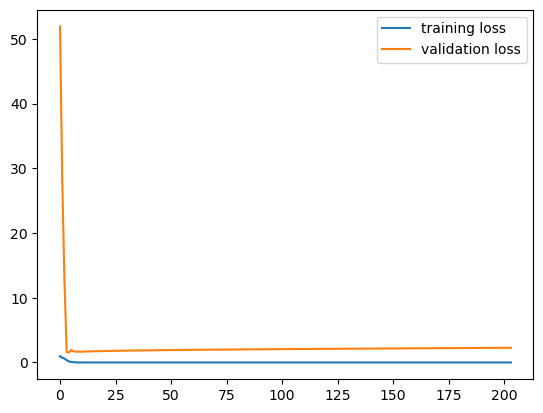

gh2ax
4931


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9439 loss_val: 7.0927 time: 8.0649s
 Epoch: 0010 loss_train: 0.0153 loss_val: 0.9097 time: 7.3962s
 Epoch: 0020 loss_train: 0.0005 loss_val: 0.6803 time: 8.7076s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.6992 time: 6.5346s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7142 time: 7.2041s
 Epoch: 0050 loss_train: 0.0001 loss_val: 0.7275 time: 7.9652s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7393 time: 8.2637s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7502 time: 6.3714s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.7605 time: 8.7760s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.7701 time: 7.8095s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.7792 time: 7.4934s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.7879 time: 7.0037s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.7962 time: 7.3643s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8041 time: 6.9208s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8120 time: 6.2905s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8196 time: 

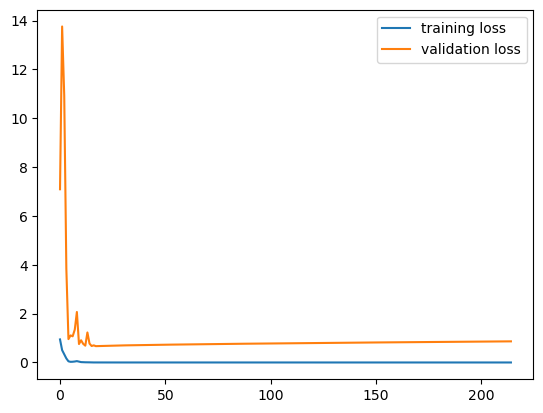

lamin
4932


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9586 loss_val: 25.9153 time: 9.1025s
 Epoch: 0010 loss_train: 0.0037 loss_val: 1.2783 time: 7.2809s
 Epoch: 0020 loss_train: 0.0027 loss_val: 1.4565 time: 7.3388s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.5173 time: 8.3840s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.5586 time: 7.7204s
 Epoch: 0050 loss_train: 0.0001 loss_val: 1.5838 time: 7.8365s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.6051 time: 7.3141s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.6238 time: 7.7522s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6411 time: 7.9731s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6570 time: 5.8310s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6722 time: 7.4008s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.6867 time: 8.7779s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.7007 time: 7.7405s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.7143 time: 8.3458s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.7274 time: 7.6870s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7401 time:

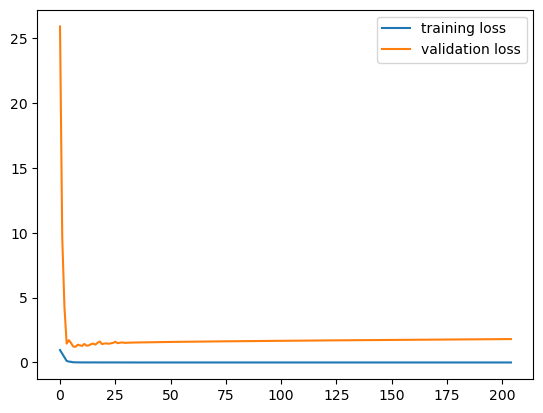

20
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
cd16
4629


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1458 loss_val: 1.3187 time: 8.1801s
 Epoch: 0010 loss_train: 0.0239 loss_val: 1.9233 time: 5.4374s
 Epoch: 0020 loss_train: 0.0064 loss_val: 1.9242 time: 5.2003s
 Epoch: 0030 loss_train: 0.0092 loss_val: 2.0468 time: 4.7186s
 Epoch: 0040 loss_train: 0.0044 loss_val: 2.1178 time: 7.8308s
 Epoch: 0050 loss_train: 0.0027 loss_val: 2.1594 time: 8.1369s
 Epoch: 0060 loss_train: 0.0013 loss_val: 2.2115 time: 7.9168s
 Epoch: 0070 loss_train: 0.0043 loss_val: 2.2561 time: 7.9755s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.2867 time: 6.8351s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.3196 time: 7.7198s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.3585 time: 7.3005s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3784 time: 6.9736s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.4069 time: 7.0090s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.4490 time: 6.6036s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.4498 time: 7.8458s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.4776 time: 

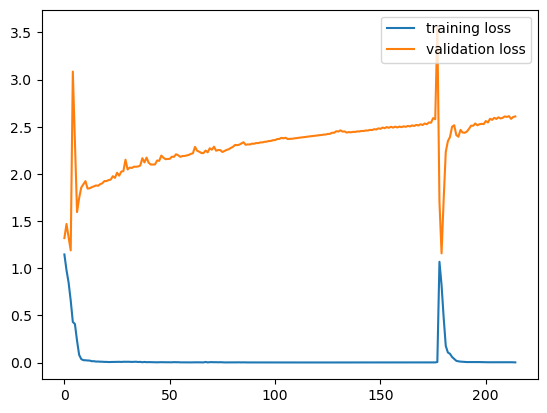

cd3
3806


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9966 loss_val: 1.1550 time: 6.6305s
 Epoch: 0010 loss_train: 0.0054 loss_val: 1.2726 time: 6.0099s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.3423 time: 3.9194s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.3807 time: 5.9759s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.4103 time: 5.8744s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4351 time: 6.6738s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4567 time: 6.7152s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4757 time: 5.6465s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4930 time: 5.5462s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5088 time: 6.6448s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5238 time: 6.4329s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5379 time: 6.8330s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5512 time: 6.9915s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5641 time: 6.2709s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5763 time: 6.6084s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5882 time: 

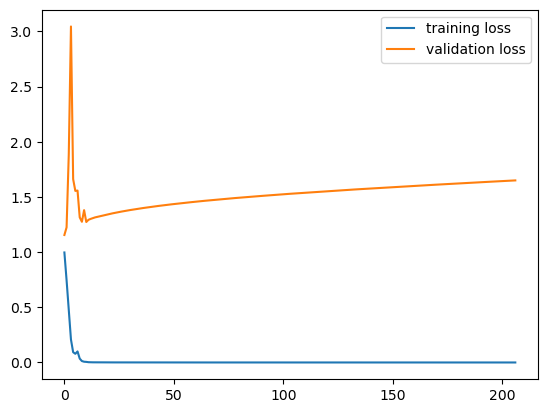

cd4
5663


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1691 loss_val: 20.7768 time: 8.8871s
 Epoch: 0010 loss_train: 0.0141 loss_val: 1.8120 time: 7.5618s
 Epoch: 0020 loss_train: 0.0123 loss_val: 2.2287 time: 10.5245s
 Epoch: 0030 loss_train: 0.0039 loss_val: 2.1233 time: 10.5502s
 Epoch: 0040 loss_train: 0.0012 loss_val: 2.1545 time: 9.3517s
 Epoch: 0050 loss_train: 0.0006 loss_val: 2.2084 time: 8.4852s
 Epoch: 0060 loss_train: 0.0012 loss_val: 2.2431 time: 6.1401s
 Epoch: 0070 loss_train: 0.0073 loss_val: 2.3074 time: 7.8425s
 Epoch: 0080 loss_train: 0.0033 loss_val: 2.3917 time: 8.0230s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.3347 time: 8.5000s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.3773 time: 9.6998s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.4092 time: 9.1993s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.4345 time: 7.8418s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.4569 time: 7.1216s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.4769 time: 11.4656s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.5007 ti

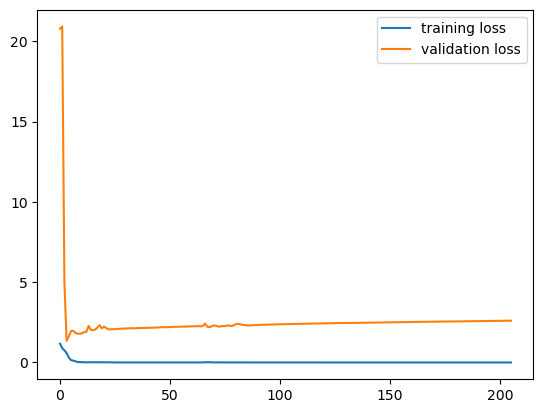

cd8
5687


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9942 loss_val: 42.9235 time: 8.9277s
 Epoch: 0010 loss_train: 0.0111 loss_val: 1.7034 time: 6.7533s
 Epoch: 0020 loss_train: 0.0030 loss_val: 1.7726 time: 8.3190s
 Epoch: 0030 loss_train: 0.0013 loss_val: 1.8687 time: 9.7976s
 Epoch: 0040 loss_train: 0.0006 loss_val: 1.9185 time: 9.0982s
 Epoch: 0050 loss_train: 0.0006 loss_val: 1.9581 time: 8.4016s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.0100 time: 8.0278s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.0488 time: 7.7375s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.0809 time: 8.2901s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1097 time: 7.3949s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1356 time: 10.5092s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1602 time: 9.1250s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.1833 time: 9.0207s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.2053 time: 9.1037s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.2265 time: 9.5380s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.2472 time

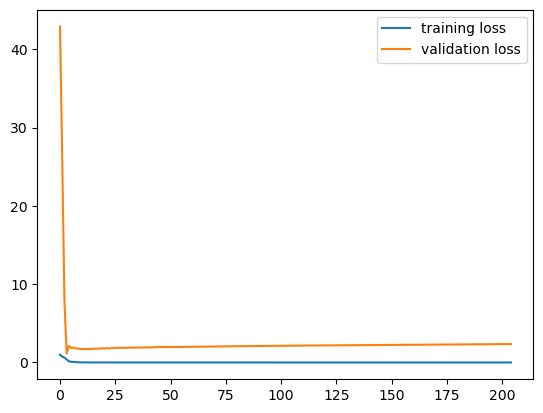

gh2ax
4889


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0259 loss_val: 5.9278 time: 8.0630s
 Epoch: 0010 loss_train: 0.0118 loss_val: 0.8178 time: 7.7613s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7651 time: 7.9224s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7886 time: 7.0349s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.8078 time: 7.7190s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.8245 time: 6.4075s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8392 time: 7.0330s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8525 time: 6.6162s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8646 time: 9.7757s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8761 time: 6.9064s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8869 time: 7.4841s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8971 time: 9.3406s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.9068 time: 8.8332s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9163 time: 9.4146s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9253 time: 8.7574s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9342 time: 

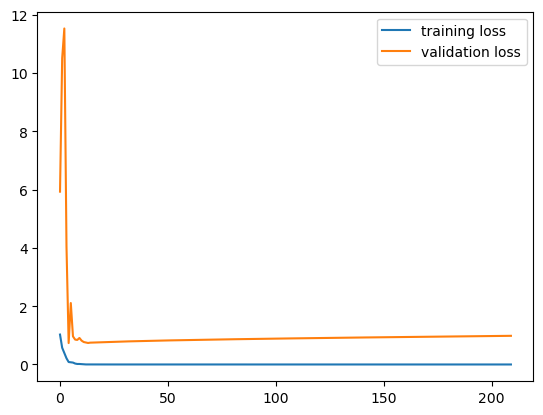

lamin
4890


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9521 loss_val: 28.6993 time: 7.4547s
 Epoch: 0010 loss_train: 0.0073 loss_val: 1.3545 time: 7.0306s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.2783 time: 6.8241s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3198 time: 5.6508s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.3514 time: 7.8844s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3775 time: 8.1758s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4000 time: 9.0390s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4201 time: 7.7237s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4383 time: 6.1871s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4552 time: 6.4442s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4710 time: 5.1802s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.4857 time: 7.7487s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.4999 time: 7.7063s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5135 time: 8.1883s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5265 time: 7.2904s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5391 time:

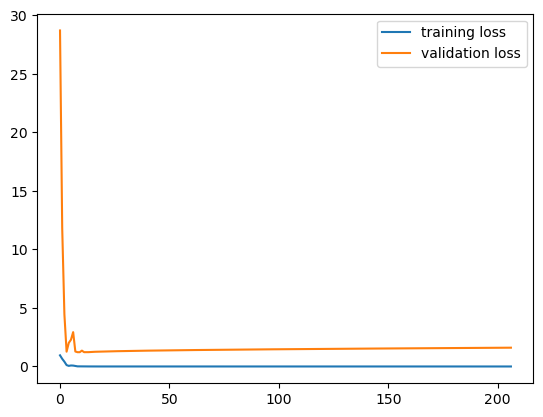

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
cd16
4560


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1481 loss_val: 1.2410 time: 7.6285s
 Epoch: 0010 loss_train: 0.0731 loss_val: 1.9116 time: 7.2267s
 Epoch: 0020 loss_train: 0.0046 loss_val: 1.8343 time: 7.4535s
 Epoch: 0030 loss_train: 0.0035 loss_val: 1.9325 time: 5.1780s
 Epoch: 0040 loss_train: 0.0044 loss_val: 1.9804 time: 5.3727s
 Epoch: 0050 loss_train: 0.0014 loss_val: 2.0268 time: 7.7096s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.0706 time: 8.7006s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.1071 time: 6.7943s
 Epoch: 0080 loss_train: 0.0180 loss_val: 2.2490 time: 7.9427s
 Epoch: 0090 loss_train: 0.0307 loss_val: 2.1089 time: 8.6035s
 Epoch: 0100 loss_train: 0.0022 loss_val: 2.0842 time: 8.1350s
 Epoch: 0110 loss_train: 0.0010 loss_val: 2.1546 time: 8.5816s
 Epoch: 0120 loss_train: 0.0016 loss_val: 2.1992 time: 5.8325s
 Epoch: 0130 loss_train: 0.0008 loss_val: 2.2194 time: 6.4611s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.2632 time: 8.0215s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.2871 time: 

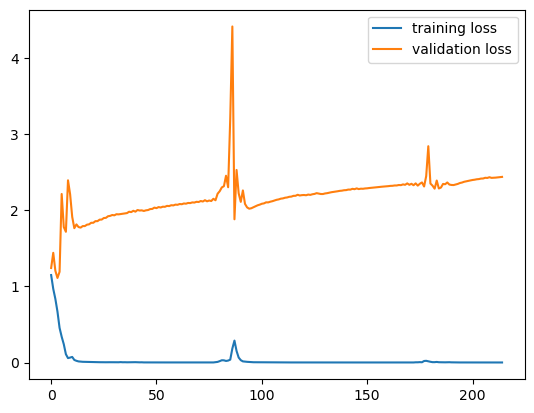

cd3
3772


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9929 loss_val: 1.1337 time: 6.0512s
 Epoch: 0010 loss_train: 0.0027 loss_val: 1.2669 time: 6.3991s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.2545 time: 7.0275s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2896 time: 6.4702s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3181 time: 6.7243s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3423 time: 6.2769s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3636 time: 6.3190s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3826 time: 6.3987s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4000 time: 6.7533s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4161 time: 5.2838s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4312 time: 6.5562s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4453 time: 5.6046s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4588 time: 6.2163s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4718 time: 6.3598s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4843 time: 5.6031s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4963 time: 

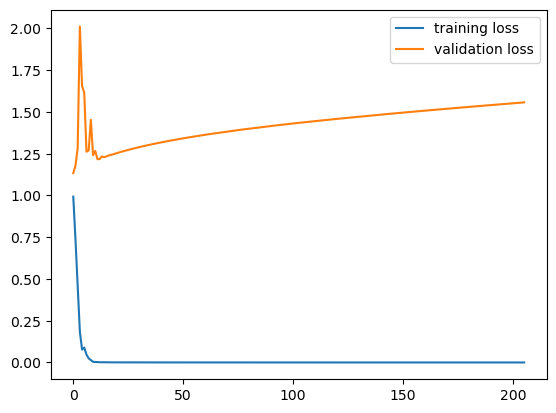

cd4
5602


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1741 loss_val: 12.4592 time: 8.8099s
 Epoch: 0010 loss_train: 0.0330 loss_val: 1.8186 time: 7.8951s
 Epoch: 0020 loss_train: 0.0034 loss_val: 1.7570 time: 7.7558s
 Epoch: 0030 loss_train: 0.0014 loss_val: 1.8178 time: 8.6691s
 Epoch: 0040 loss_train: 0.0013 loss_val: 1.8864 time: 8.4878s
 Epoch: 0050 loss_train: 0.0045 loss_val: 1.9125 time: 9.5686s
 Epoch: 0060 loss_train: 0.0066 loss_val: 1.9560 time: 8.7236s
 Epoch: 0070 loss_train: 0.0030 loss_val: 2.0822 time: 8.4716s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.0108 time: 8.9504s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.0536 time: 9.8159s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.1197 time: 8.9022s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.1288 time: 7.8106s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.1691 time: 8.5619s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.1970 time: 9.7423s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.2099 time: 9.2622s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.2756 time:

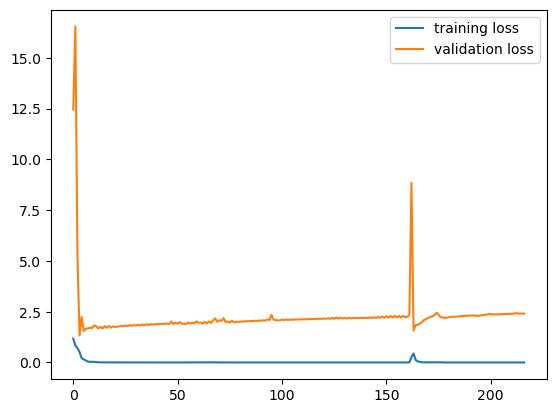

cd8
5625


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9769 loss_val: 41.5659 time: 8.3309s
 Epoch: 0010 loss_train: 0.0157 loss_val: 1.5244 time: 9.9117s
 Epoch: 0020 loss_train: 0.0065 loss_val: 1.6359 time: 8.4697s
 Epoch: 0030 loss_train: 0.0033 loss_val: 1.6872 time: 9.6557s
 Epoch: 0040 loss_train: 0.0013 loss_val: 1.7562 time: 8.6191s
 Epoch: 0050 loss_train: 0.0008 loss_val: 1.7897 time: 9.2575s
 Epoch: 0060 loss_train: 0.0009 loss_val: 1.8235 time: 8.7322s
 Epoch: 0070 loss_train: 0.0007 loss_val: 1.8668 time: 9.7075s
 Epoch: 0080 loss_train: 0.0007 loss_val: 1.8855 time: 10.1035s
 Epoch: 0090 loss_train: 0.0006 loss_val: 1.9228 time: 7.9059s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.0774 time: 7.6834s
 Epoch: 0110 loss_train: 0.0149 loss_val: 1.8436 time: 8.1996s
 Epoch: 0120 loss_train: 0.0033 loss_val: 1.8949 time: 9.6993s
 Epoch: 0130 loss_train: 0.0016 loss_val: 1.9889 time: 8.9061s
 Epoch: 0140 loss_train: 0.0013 loss_val: 2.0242 time: 8.8167s
 Epoch: 0150 loss_train: 0.0007 loss_val: 2.0436 time

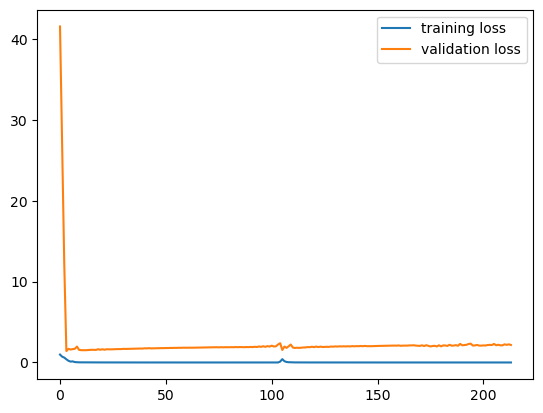

gh2ax
4892


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0080 loss_val: 5.0712 time: 7.5351s
 Epoch: 0010 loss_train: 0.0030 loss_val: 0.6844 time: 6.7299s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7188 time: 7.2354s
 Epoch: 0030 loss_train: 0.0004 loss_val: 0.7428 time: 6.9168s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7621 time: 7.4241s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.7784 time: 7.9638s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7929 time: 8.1714s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8058 time: 7.8359s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8178 time: 8.0852s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8289 time: 7.2078s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8393 time: 6.9280s
 Epoch: 0110 loss_train: 0.0001 loss_val: 0.8493 time: 5.7726s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8587 time: 6.6158s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8677 time: 7.7404s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8765 time: 7.4223s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8851 time: 

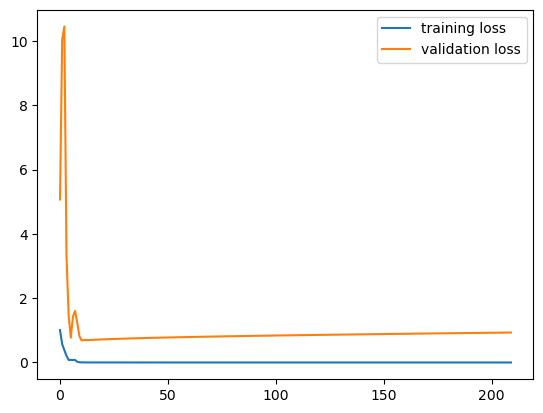

lamin
4893


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9498 loss_val: 27.5614 time: 6.0109s
 Epoch: 0010 loss_train: 0.0034 loss_val: 1.2364 time: 7.9902s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.2857 time: 5.6200s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3269 time: 7.8829s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3585 time: 6.8226s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3845 time: 7.5840s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4070 time: 7.8516s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4270 time: 4.4075s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4453 time: 5.7070s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4621 time: 7.1960s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4779 time: 9.3210s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4929 time: 6.9967s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.5071 time: 7.8312s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5209 time: 6.7086s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5341 time: 7.6482s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5469 time:

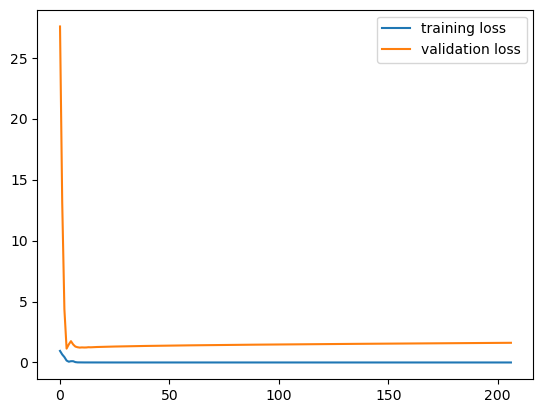

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
22
cd16
4544


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1164 loss_val: 1.3568 time: 6.4672s
 Epoch: 0010 loss_train: 0.0208 loss_val: 1.8088 time: 9.3229s
 Epoch: 0020 loss_train: 0.0080 loss_val: 1.8896 time: 7.7526s
 Epoch: 0030 loss_train: 0.0063 loss_val: 1.9691 time: 7.2540s
 Epoch: 0040 loss_train: 0.0035 loss_val: 2.0716 time: 7.4762s
 Epoch: 0050 loss_train: 0.0017 loss_val: 2.0649 time: 8.0829s
 Epoch: 0060 loss_train: 0.0011 loss_val: 2.1036 time: 7.0843s
 Epoch: 0070 loss_train: 0.0013 loss_val: 2.1293 time: 8.2460s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.1619 time: 8.8995s
 Epoch: 0090 loss_train: 0.0012 loss_val: 2.1841 time: 6.8803s
 Epoch: 0100 loss_train: 0.2128 loss_val: 2.4109 time: 7.4524s
 Epoch: 0110 loss_train: 0.0043 loss_val: 2.1612 time: 7.0495s
 Epoch: 0120 loss_train: 0.0015 loss_val: 2.2604 time: 7.2380s
 Epoch: 0130 loss_train: 0.0019 loss_val: 2.3255 time: 6.1343s
 Epoch: 0140 loss_train: 0.0010 loss_val: 2.3520 time: 7.7794s
 Epoch: 0150 loss_train: 0.0010 loss_val: 2.3856 time: 

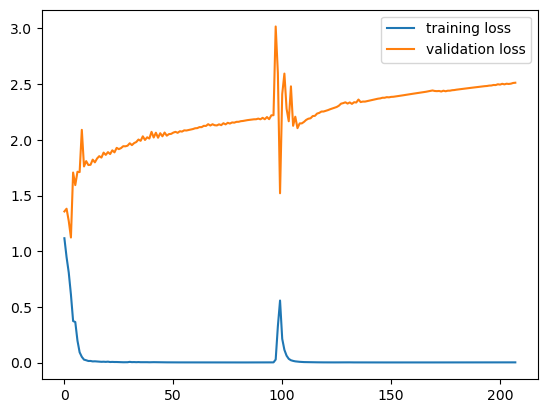

cd3
3781


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0058 loss_val: 1.1266 time: 5.6865s
 Epoch: 0010 loss_train: 0.0094 loss_val: 1.7152 time: 6.4195s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.3439 time: 5.0467s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3685 time: 5.6144s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3900 time: 6.1746s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4089 time: 7.1178s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4261 time: 6.5960s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4418 time: 6.5825s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4565 time: 5.5315s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4702 time: 7.4195s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4832 time: 6.9698s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4957 time: 3.3551s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5077 time: 5.4636s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5192 time: 5.6413s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5303 time: 6.7613s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5410 time: 

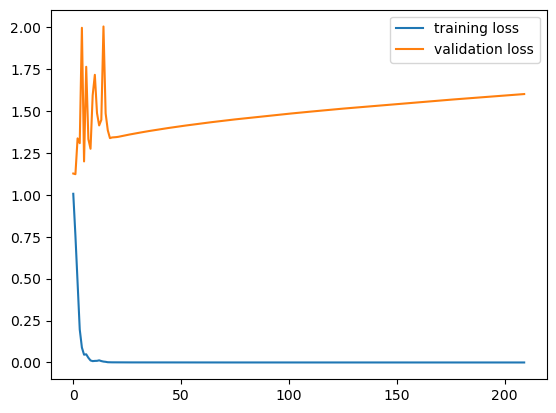

cd4
5579


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1745 loss_val: 10.5161 time: 8.1096s
 Epoch: 0010 loss_train: 0.0419 loss_val: 2.1333 time: 8.8290s
 Epoch: 0020 loss_train: 0.0039 loss_val: 1.9124 time: 7.6422s
 Epoch: 0030 loss_train: 0.0016 loss_val: 1.9869 time: 8.5215s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.0356 time: 8.7394s
 Epoch: 0050 loss_train: 0.0010 loss_val: 2.0819 time: 7.1208s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.1242 time: 8.0149s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.1607 time: 8.4315s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.1992 time: 8.3310s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.2529 time: 6.9401s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.2527 time: 8.4133s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.2974 time: 7.0450s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.3210 time: 6.5507s
 Epoch: 0130 loss_train: 0.1245 loss_val: 1.8758 time: 8.9834s
 Epoch: 0140 loss_train: 0.0029 loss_val: 2.3475 time: 9.5218s
 Epoch: 0150 loss_train: 0.0017 loss_val: 2.3844 time:

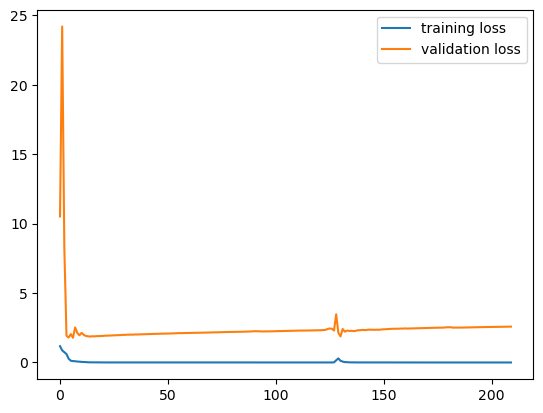

cd8
5605


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9963 loss_val: 47.3456 time: 8.6940s
 Epoch: 0010 loss_train: 0.0118 loss_val: 1.5968 time: 8.8000s
 Epoch: 0020 loss_train: 0.0033 loss_val: 1.7151 time: 8.4812s
 Epoch: 0030 loss_train: 0.0010 loss_val: 1.7874 time: 7.6964s
 Epoch: 0040 loss_train: 0.0008 loss_val: 1.8411 time: 7.9185s
 Epoch: 0050 loss_train: 0.0006 loss_val: 1.8833 time: 10.1029s
 Epoch: 0060 loss_train: 0.0005 loss_val: 1.9211 time: 8.9426s
 Epoch: 0070 loss_train: 0.0013 loss_val: 1.9178 time: 7.4204s
 Epoch: 0080 loss_train: 0.0018 loss_val: 1.9572 time: 8.2175s
 Epoch: 0090 loss_train: 0.0013 loss_val: 2.0130 time: 9.7195s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.0734 time: 8.6979s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.1058 time: 9.4790s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.1347 time: 10.0928s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.1547 time: 7.3869s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.1762 time: 8.6847s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.1985 tim

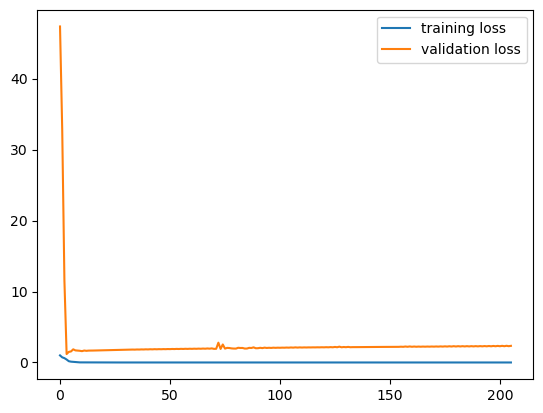

gh2ax
4926


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0010 loss_val: 6.7725 time: 7.6663s
 Epoch: 0010 loss_train: 0.0026 loss_val: 0.6838 time: 7.0370s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7110 time: 7.2698s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7340 time: 7.1117s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7528 time: 7.7254s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.7689 time: 5.8571s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7829 time: 6.7396s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7957 time: 7.7203s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8074 time: 7.6111s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8184 time: 7.3723s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8285 time: 7.4046s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8384 time: 6.7965s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8477 time: 6.7313s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8566 time: 5.9343s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8650 time: 6.4509s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8735 time: 

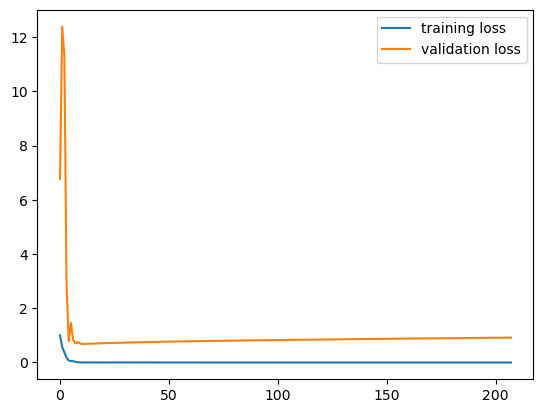

lamin
4927


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9577 loss_val: 25.3154 time: 5.3007s
 Epoch: 0010 loss_train: 0.0029 loss_val: 1.3079 time: 6.9905s
 Epoch: 0020 loss_train: 0.0005 loss_val: 1.3722 time: 7.1985s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.4117 time: 6.7043s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4430 time: 5.2038s
 Epoch: 0050 loss_train: 0.0001 loss_val: 1.4696 time: 7.2882s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4931 time: 7.3475s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5143 time: 7.1704s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5337 time: 6.3872s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5518 time: 5.7101s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5689 time: 8.5747s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.5851 time: 6.7319s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.6005 time: 8.3287s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6153 time: 6.7872s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6298 time: 7.3579s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6436 time:

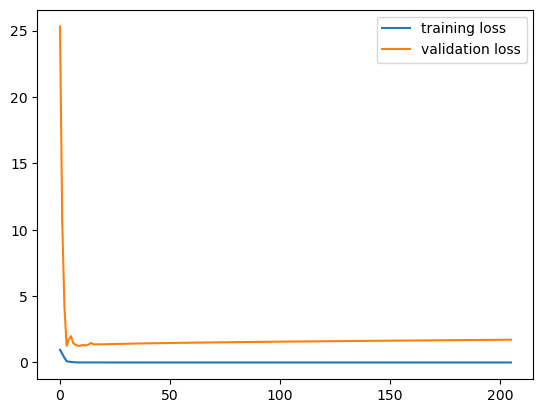

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
23
cd16
4608


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1633 loss_val: 1.1665 time: 6.6913s
 Epoch: 0010 loss_train: 0.0201 loss_val: 1.8192 time: 6.5921s
 Epoch: 0020 loss_train: 0.0077 loss_val: 1.9194 time: 6.6169s
 Epoch: 0030 loss_train: 0.0050 loss_val: 1.9904 time: 5.7618s
 Epoch: 0040 loss_train: 0.0108 loss_val: 2.0212 time: 6.0634s
 Epoch: 0050 loss_train: 0.0030 loss_val: 2.0623 time: 6.9735s
 Epoch: 0060 loss_train: 0.0012 loss_val: 2.1282 time: 7.4367s
 Epoch: 0070 loss_train: 0.0010 loss_val: 2.1638 time: 6.4959s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.2070 time: 8.1877s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.2393 time: 6.8261s
 Epoch: 0100 loss_train: 0.0010 loss_val: 2.2709 time: 9.0745s
 Epoch: 0110 loss_train: 0.0008 loss_val: 2.2785 time: 6.5496s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.3085 time: 6.8830s
 Epoch: 0130 loss_train: 0.0008 loss_val: 2.3513 time: 6.7992s
 Epoch: 0140 loss_train: 0.0007 loss_val: 2.3736 time: 7.0442s
 Epoch: 0150 loss_train: 1.0343 loss_val: 1.9675 time: 

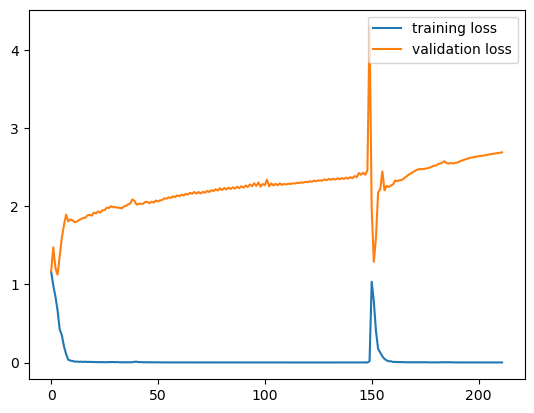

cd3
3822


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0191 loss_val: 1.1987 time: 6.1060s
 Epoch: 0010 loss_train: 0.0109 loss_val: 1.4580 time: 6.2518s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.3600 time: 4.2659s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3880 time: 6.5045s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.4116 time: 5.7050s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4324 time: 5.9707s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4510 time: 6.2560s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4679 time: 5.7538s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4834 time: 5.1046s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4980 time: 5.1182s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5119 time: 5.1098s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5250 time: 6.5370s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5377 time: 4.4572s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5498 time: 4.7793s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5614 time: 5.8174s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5728 time: 

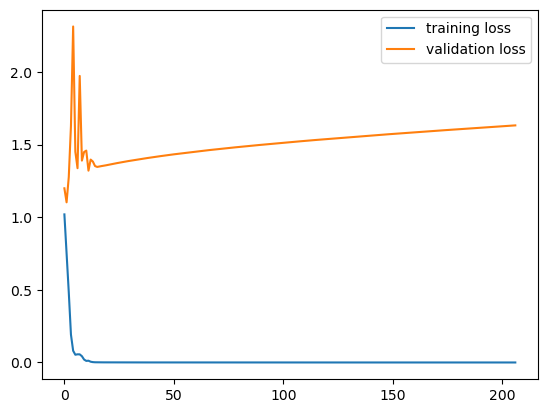

cd4
5637


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1300 loss_val: 20.3816 time: 8.0212s
 Epoch: 0010 loss_train: 0.0289 loss_val: 1.7664 time: 8.7685s
 Epoch: 0020 loss_train: 0.0025 loss_val: 1.7751 time: 8.8019s
 Epoch: 0030 loss_train: 0.0050 loss_val: 1.8909 time: 8.4695s
 Epoch: 0040 loss_train: 0.0024 loss_val: 1.9210 time: 7.5563s
 Epoch: 0050 loss_train: 0.0007 loss_val: 1.9530 time: 8.7735s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.9983 time: 7.1847s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.0316 time: 7.7063s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.0582 time: 5.7981s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.0864 time: 9.0442s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.1168 time: 9.1209s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.1452 time: 8.5724s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.1736 time: 8.6598s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.1638 time: 8.1121s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.1841 time: 8.0688s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.2234 time:

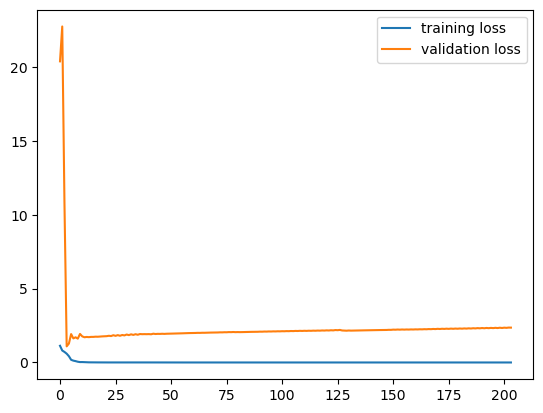

cd8
5659


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9701 loss_val: 51.4084 time: 7.7097s
 Epoch: 0010 loss_train: 0.0172 loss_val: 1.8087 time: 9.2446s
 Epoch: 0020 loss_train: 0.0032 loss_val: 1.6403 time: 9.5678s
 Epoch: 0030 loss_train: 0.0017 loss_val: 1.6766 time: 8.8201s
 Epoch: 0040 loss_train: 0.0030 loss_val: 1.7270 time: 9.1256s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.7903 time: 9.4116s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.8285 time: 8.6104s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.8603 time: 8.1302s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.8873 time: 9.2752s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.9112 time: 8.5681s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.9336 time: 8.9144s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.9542 time: 8.7503s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.9739 time: 8.5472s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.9929 time: 7.4952s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.0113 time: 8.2132s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.0290 time:

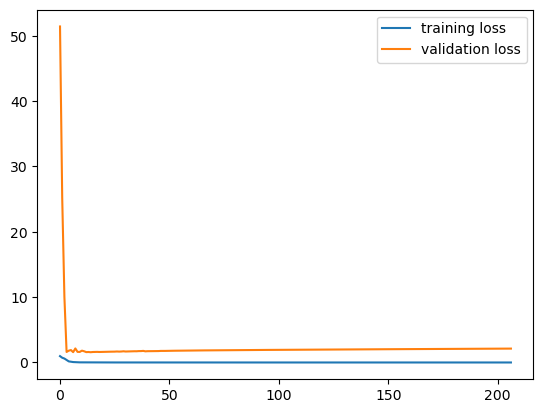

gh2ax
4938


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0013 loss_val: 5.7346 time: 7.4788s
 Epoch: 0010 loss_train: 0.0053 loss_val: 0.9103 time: 8.1329s
 Epoch: 0020 loss_train: 0.0005 loss_val: 0.7576 time: 7.2870s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7827 time: 8.0193s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.8032 time: 6.7407s
 Epoch: 0050 loss_train: 0.0001 loss_val: 0.8207 time: 7.5341s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8362 time: 8.1432s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8502 time: 6.9618s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8631 time: 6.9927s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8753 time: 6.8852s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8867 time: 7.5037s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8976 time: 6.8876s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.9079 time: 6.6201s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9179 time: 7.4093s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9275 time: 7.5331s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9368 time: 

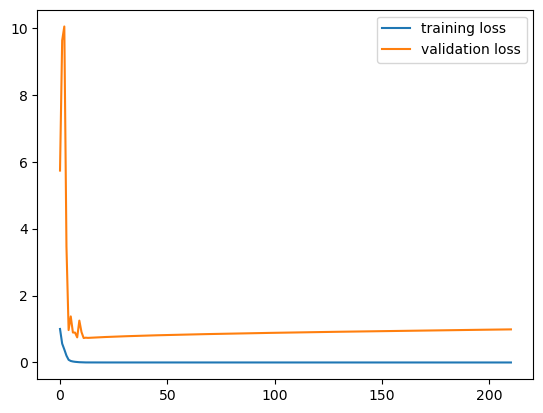

lamin
4939


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9567 loss_val: 22.8099 time: 6.7191s
 Epoch: 0010 loss_train: 0.0022 loss_val: 1.3004 time: 5.7653s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.3700 time: 7.0645s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.4155 time: 5.9424s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4505 time: 7.6711s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4795 time: 8.2069s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.5047 time: 7.1748s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5271 time: 7.8555s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5475 time: 7.4578s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5664 time: 6.3434s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5841 time: 7.8134s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6009 time: 6.0897s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.6169 time: 6.2230s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6320 time: 7.1456s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6468 time: 7.3018s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6612 time:

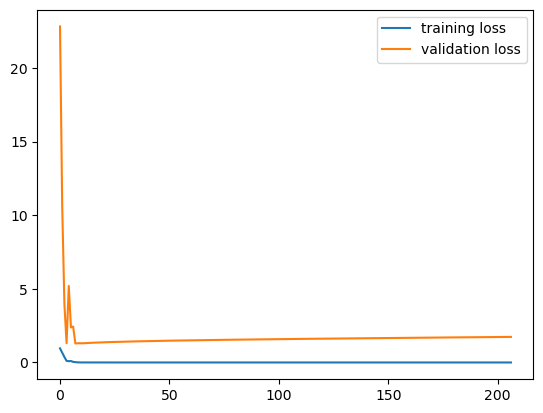

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
cd16
4555


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1254 loss_val: 1.1545 time: 6.4101s
 Epoch: 0010 loss_train: 0.0263 loss_val: 1.8218 time: 4.7894s
 Epoch: 0020 loss_train: 0.0058 loss_val: 1.9315 time: 7.0108s
 Epoch: 0030 loss_train: 0.0087 loss_val: 2.0879 time: 6.6231s
 Epoch: 0040 loss_train: 0.0042 loss_val: 2.1330 time: 6.8342s
 Epoch: 0050 loss_train: 0.0006 loss_val: 2.1488 time: 6.7959s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2072 time: 7.0277s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2508 time: 7.8757s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2867 time: 7.3590s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3184 time: 6.2344s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3467 time: 7.9142s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3726 time: 6.8366s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3968 time: 7.8126s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4196 time: 5.2174s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4416 time: 6.9094s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4624 time: 

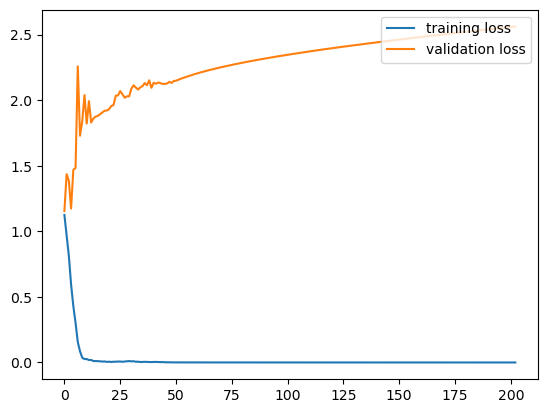

cd3
3760


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0034 loss_val: 1.1745 time: 4.7572s
 Epoch: 0010 loss_train: 0.0038 loss_val: 1.1802 time: 5.7044s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.1983 time: 5.6107s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2341 time: 6.1681s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2619 time: 6.0512s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2852 time: 5.3724s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3055 time: 5.1520s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3236 time: 5.2414s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3400 time: 6.8221s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3551 time: 4.0900s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3692 time: 5.9119s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3825 time: 6.3620s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3953 time: 6.2750s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4074 time: 5.3606s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4190 time: 6.3339s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4302 time: 

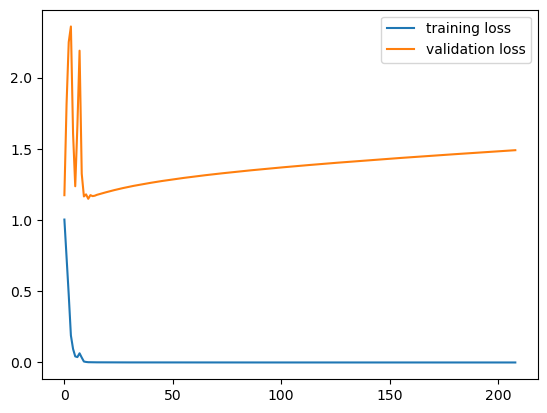

cd4
5580


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1438 loss_val: 14.2189 time: 9.3742s
 Epoch: 0010 loss_train: 0.0137 loss_val: 1.8519 time: 7.2032s
 Epoch: 0020 loss_train: 0.0017 loss_val: 1.9808 time: 7.9209s
 Epoch: 0030 loss_train: 0.0033 loss_val: 2.0257 time: 8.5366s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.0726 time: 7.5032s
 Epoch: 0050 loss_train: 0.0002 loss_val: 2.1323 time: 8.2047s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.1741 time: 8.2975s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.2096 time: 8.5281s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.2413 time: 6.9567s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2703 time: 8.7825s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2973 time: 6.4808s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3229 time: 8.2377s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.3470 time: 7.8445s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.3703 time: 5.9390s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.3930 time: 8.4072s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.4148 time:

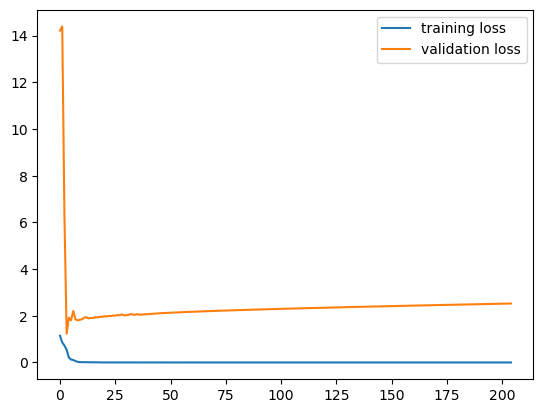

cd8
5604


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9717 loss_val: 46.5682 time: 7.8096s
 Epoch: 0010 loss_train: 0.0141 loss_val: 1.8013 time: 6.3990s
 Epoch: 0020 loss_train: 0.0036 loss_val: 1.7532 time: 7.4162s
 Epoch: 0030 loss_train: 0.0039 loss_val: 1.8657 time: 6.4003s
 Epoch: 0040 loss_train: 0.0015 loss_val: 1.8765 time: 7.6650s
 Epoch: 0050 loss_train: 0.0011 loss_val: 1.9111 time: 8.2364s
 Epoch: 0060 loss_train: 0.0009 loss_val: 1.9484 time: 7.3215s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.0151 time: 8.4485s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.0029 time: 7.5607s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.0453 time: 8.9679s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.0903 time: 9.4739s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.0981 time: 9.3343s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.1555 time: 7.4259s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.1619 time: 6.8949s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.2131 time: 8.3139s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.2238 time:

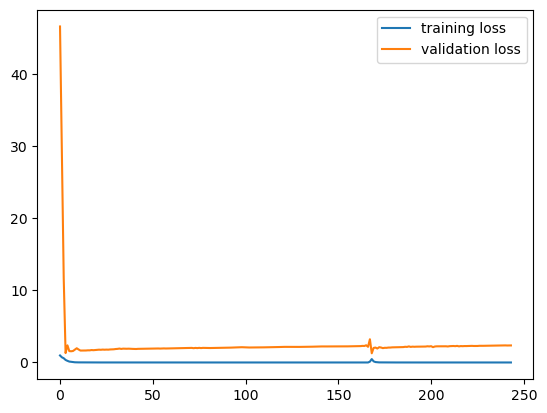

gh2ax
4837


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9805 loss_val: 4.6989 time: 7.9781s
 Epoch: 0010 loss_train: 0.0077 loss_val: 0.6650 time: 8.4024s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.5962 time: 5.9728s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.6177 time: 7.7143s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.6353 time: 8.2772s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.6502 time: 6.7960s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.6632 time: 7.0823s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.6750 time: 6.8065s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.6857 time: 5.7547s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.6958 time: 7.4676s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.7052 time: 7.0951s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.7142 time: 7.7929s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.7226 time: 4.9439s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.7308 time: 6.8203s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.7386 time: 7.8543s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.7463 time: 

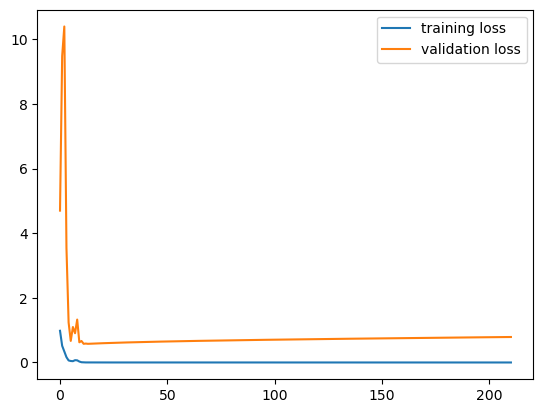

lamin
4838


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9246 loss_val: 23.4949 time: 5.4491s
 Epoch: 0010 loss_train: 0.0021 loss_val: 1.0282 time: 8.3679s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.0948 time: 5.8306s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.1378 time: 6.9570s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.1703 time: 7.7463s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1968 time: 7.7252s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.2194 time: 7.7273s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2394 time: 7.0745s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2573 time: 8.0061s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2738 time: 6.3514s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2893 time: 6.9308s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.3038 time: 6.5716s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.3175 time: 7.3126s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.3307 time: 8.3738s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3436 time: 6.9286s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3558 time:

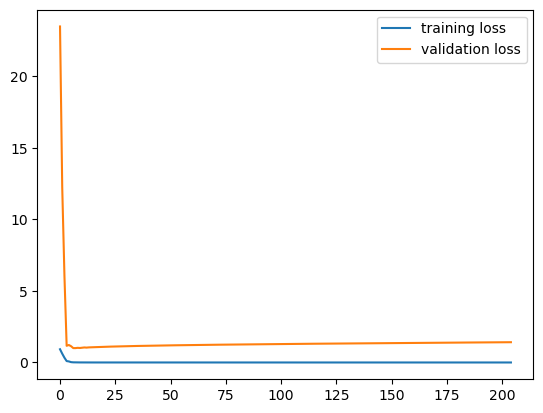

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
cd16
4490


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1349 loss_val: 1.2875 time: 6.3242s
 Epoch: 0010 loss_train: 0.0047 loss_val: 1.8163 time: 5.9069s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.8980 time: 7.1833s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.9715 time: 6.1691s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.0268 time: 6.7904s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0716 time: 5.8088s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.1101 time: 6.2264s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1441 time: 7.1828s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1747 time: 5.4747s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2027 time: 5.5276s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2286 time: 6.4052s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2529 time: 8.2671s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2759 time: 7.3557s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2979 time: 6.5764s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3191 time: 5.6690s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3393 time: 

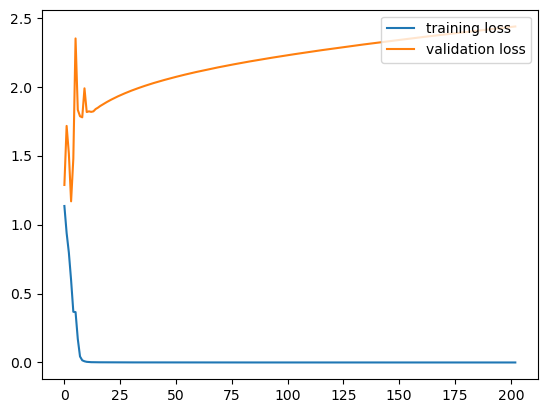

cd3
3802


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9793 loss_val: 1.3661 time: 4.4920s
 Epoch: 0010 loss_train: 0.0062 loss_val: 1.1120 time: 5.6611s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.1176 time: 5.8897s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.1516 time: 4.3834s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1792 time: 6.0170s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2026 time: 6.1045s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2232 time: 4.4850s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2416 time: 5.0780s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2584 time: 5.1879s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2740 time: 6.4756s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2885 time: 5.7694s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3022 time: 6.0182s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3153 time: 6.2093s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3277 time: 5.5538s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3398 time: 5.7305s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3514 time: 

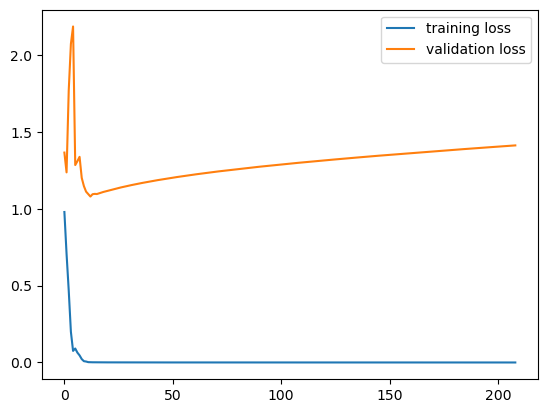

cd4
5518


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1442 loss_val: 13.2749 time: 7.4470s
 Epoch: 0010 loss_train: 0.0020 loss_val: 1.7894 time: 7.4791s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.8655 time: 8.0431s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.9215 time: 7.2250s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.9662 time: 6.7073s
 Epoch: 0050 loss_train: 0.0002 loss_val: 2.0041 time: 7.6468s
 Epoch: 0060 loss_train: 0.0001 loss_val: 2.0374 time: 5.8296s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.0674 time: 8.4192s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.0949 time: 7.0274s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1205 time: 8.2062s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1446 time: 7.9414s
 Epoch: 0110 loss_train: 0.0000 loss_val: 2.1676 time: 7.3663s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.1897 time: 7.5538s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.2109 time: 7.2778s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.2313 time: 9.1535s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.2513 time:

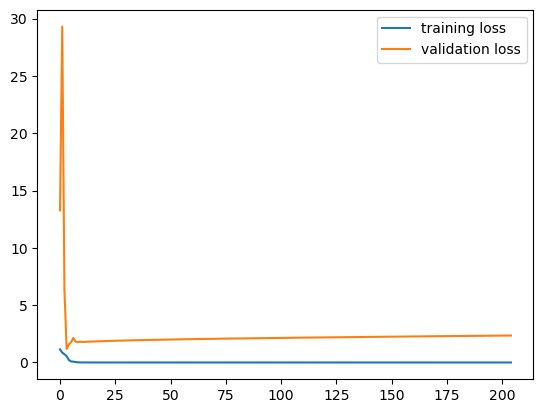

cd8
5545


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9987 loss_val: 41.5740 time: 10.0735s
 Epoch: 0010 loss_train: 0.0039 loss_val: 1.8011 time: 8.3635s
 Epoch: 0020 loss_train: 0.0005 loss_val: 1.7675 time: 8.6869s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.8209 time: 9.4948s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.8636 time: 6.8809s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.9001 time: 8.0365s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.9323 time: 8.9260s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.9611 time: 8.9057s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.9877 time: 8.8286s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0124 time: 9.3765s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0358 time: 10.5656s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.0580 time: 9.5827s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.0791 time: 8.7827s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.0998 time: 9.2144s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.1197 time: 8.7484s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.1391 tim

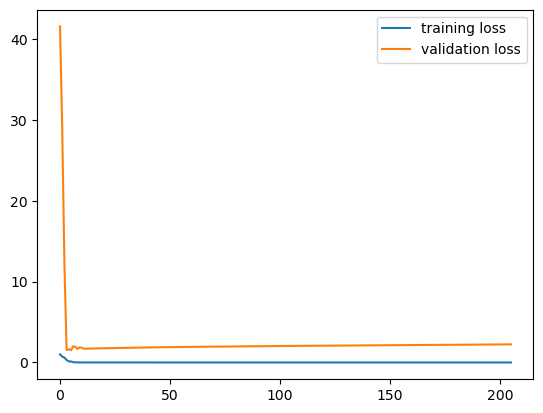

gh2ax
4931


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9558 loss_val: 6.6200 time: 7.2811s
 Epoch: 0010 loss_train: 0.0142 loss_val: 1.1489 time: 5.7743s
 Epoch: 0020 loss_train: 0.0004 loss_val: 0.7181 time: 6.0584s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7355 time: 7.7969s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7508 time: 7.9421s
 Epoch: 0050 loss_train: 0.0001 loss_val: 0.7645 time: 7.6759s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7768 time: 8.3435s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7884 time: 8.1954s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.7992 time: 7.9683s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8094 time: 8.4709s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8191 time: 6.0438s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8285 time: 6.6118s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8375 time: 7.7550s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8462 time: 7.9878s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8547 time: 7.8897s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8631 time: 

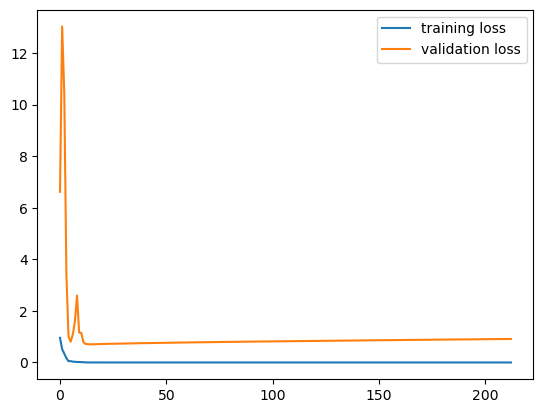

lamin
4932


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9611 loss_val: 27.9532 time: 8.4239s
 Epoch: 0010 loss_train: 0.0076 loss_val: 1.4053 time: 8.6323s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.3165 time: 5.6187s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.3535 time: 6.2262s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.3832 time: 8.0446s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4081 time: 7.5964s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4304 time: 8.0919s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4501 time: 7.5630s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4681 time: 8.3042s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4850 time: 6.8631s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5010 time: 8.8794s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.5162 time: 7.1859s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.5307 time: 6.8220s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5445 time: 9.0469s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5580 time: 8.5263s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5710 time:

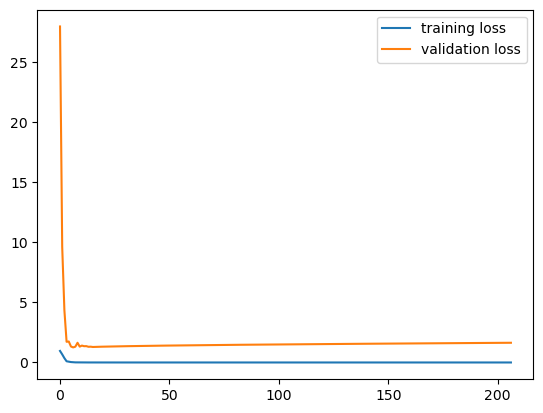

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
cd16
4629


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1617 loss_val: 1.3320 time: 7.5168s
 Epoch: 0010 loss_train: 0.0209 loss_val: 1.8340 time: 7.2489s
 Epoch: 0020 loss_train: 0.0048 loss_val: 1.9178 time: 8.1404s
 Epoch: 0030 loss_train: 0.0057 loss_val: 2.0223 time: 7.9179s
 Epoch: 0040 loss_train: 0.0026 loss_val: 2.0623 time: 7.6873s
 Epoch: 0050 loss_train: 0.0020 loss_val: 2.1176 time: 6.4408s
 Epoch: 0060 loss_train: 0.0019 loss_val: 2.1684 time: 6.5909s
 Epoch: 0070 loss_train: 0.0016 loss_val: 2.1870 time: 8.5189s
 Epoch: 0080 loss_train: 0.0017 loss_val: 2.2301 time: 7.5557s
 Epoch: 0090 loss_train: 0.0017 loss_val: 2.2801 time: 7.8873s
 Epoch: 0100 loss_train: 0.0014 loss_val: 2.2702 time: 7.4429s
 Epoch: 0110 loss_train: 0.0014 loss_val: 2.3057 time: 6.8159s
 Epoch: 0120 loss_train: 0.4388 loss_val: 2.0469 time: 9.1050s
 Epoch: 0130 loss_train: 0.0035 loss_val: 2.2191 time: 7.0465s
 Epoch: 0140 loss_train: 0.0025 loss_val: 2.3212 time: 6.9187s
 Epoch: 0150 loss_train: 0.0016 loss_val: 2.3501 time: 

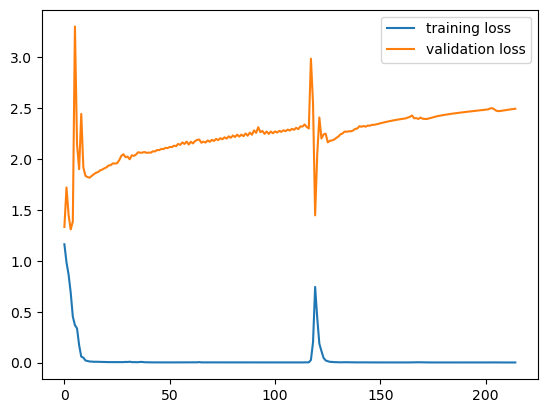

cd3
3806


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9958 loss_val: 1.1247 time: 6.4998s
 Epoch: 0010 loss_train: 0.0045 loss_val: 1.2516 time: 5.2388s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.3144 time: 5.5994s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3472 time: 6.5591s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3747 time: 5.5105s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3981 time: 6.1993s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4188 time: 5.5149s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4375 time: 5.9837s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4545 time: 5.4492s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4704 time: 7.0069s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4851 time: 5.6033s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4991 time: 6.4785s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5124 time: 4.4165s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5251 time: 6.0898s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5374 time: 5.7960s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5493 time: 

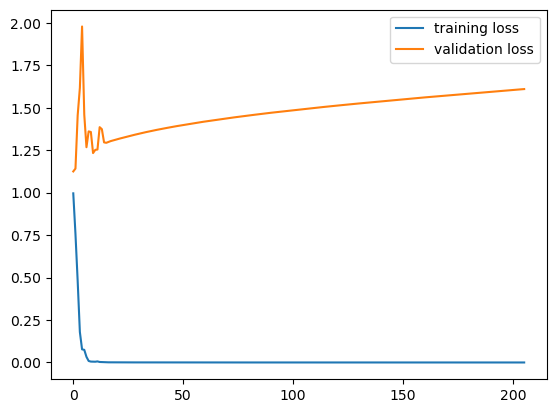

cd4
5663


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1412 loss_val: 22.6854 time: 8.4690s
 Epoch: 0010 loss_train: 0.0110 loss_val: 1.8354 time: 9.4645s
 Epoch: 0020 loss_train: 0.0018 loss_val: 1.9500 time: 9.2687s
 Epoch: 0030 loss_train: 0.0020 loss_val: 2.0257 time: 9.0600s
 Epoch: 0040 loss_train: 0.0007 loss_val: 2.0547 time: 9.5805s
 Epoch: 0050 loss_train: 0.0006 loss_val: 2.1073 time: 8.0495s
 Epoch: 0060 loss_train: 0.0004 loss_val: 2.1484 time: 7.2017s
 Epoch: 0070 loss_train: 0.0004 loss_val: 2.1862 time: 9.7308s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.2246 time: 8.8249s
 Epoch: 0090 loss_train: 0.0003 loss_val: 2.2464 time: 8.1029s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.2837 time: 8.5842s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.3149 time: 8.2024s
 Epoch: 0120 loss_train: 0.0434 loss_val: 2.0620 time: 8.2044s
 Epoch: 0130 loss_train: 0.0012 loss_val: 2.2322 time: 7.8251s
 Epoch: 0140 loss_train: 0.0009 loss_val: 2.2923 time: 9.4397s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.3300 time:

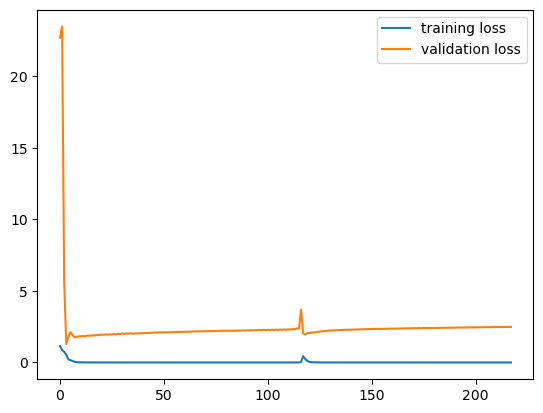

cd8
5687


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0225 loss_val: 40.7144 time: 7.7064s
 Epoch: 0010 loss_train: 0.0109 loss_val: 1.7063 time: 9.2059s
 Epoch: 0020 loss_train: 0.0037 loss_val: 1.7880 time: 9.9123s
 Epoch: 0030 loss_train: 0.0032 loss_val: 1.8662 time: 8.6782s
 Epoch: 0040 loss_train: 0.0023 loss_val: 1.9182 time: 9.2339s
 Epoch: 0050 loss_train: 0.0015 loss_val: 1.9547 time: 7.5069s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.9985 time: 9.3863s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.0622 time: 9.1875s
 Epoch: 0080 loss_train: 0.0225 loss_val: 3.2266 time: 6.9978s
 Epoch: 0090 loss_train: 0.0035 loss_val: 2.0048 time: 6.7117s
 Epoch: 0100 loss_train: 0.0028 loss_val: 2.0994 time: 4.5911s
 Epoch: 0110 loss_train: 0.0013 loss_val: 2.1374 time: 10.6134s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.1924 time: 9.5333s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.2288 time: 11.2618s
 Epoch: 0140 loss_train: 0.0002 loss_val: 2.2615 time: 9.2328s
 Epoch: 0150 loss_train: 0.0002 loss_val: 2.2872 tim

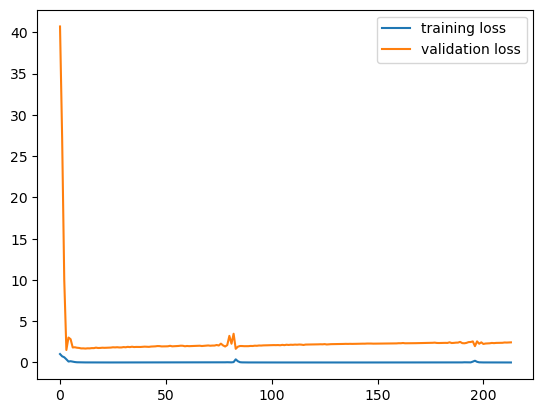

gh2ax
4889


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0641 loss_val: 6.3881 time: 5.7358s
 Epoch: 0010 loss_train: 0.0030 loss_val: 0.6804 time: 6.5791s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7286 time: 8.5136s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7531 time: 7.3936s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7737 time: 7.7649s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.7912 time: 6.0659s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8068 time: 6.0221s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8206 time: 7.1398s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8335 time: 5.9961s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8453 time: 6.4878s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8565 time: 6.5190s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8672 time: 6.8263s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8773 time: 6.8280s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8869 time: 5.8984s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8963 time: 7.3662s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9055 time: 

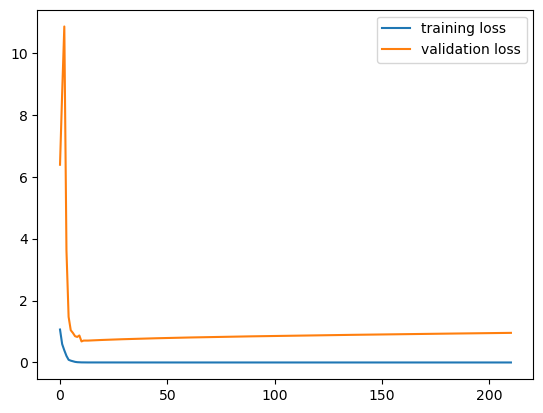

lamin
4890


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9727 loss_val: 24.2375 time: 7.1732s
 Epoch: 0010 loss_train: 0.0028 loss_val: 1.2407 time: 6.0527s
 Epoch: 0020 loss_train: 0.0042 loss_val: 1.4026 time: 6.7481s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.4087 time: 6.5154s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4418 time: 5.7134s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4681 time: 4.9114s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4907 time: 6.4108s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5109 time: 6.0076s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5293 time: 5.7553s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5465 time: 6.8194s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5625 time: 8.4861s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.5776 time: 6.9024s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.5923 time: 8.2076s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6063 time: 6.8054s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6198 time: 7.2943s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6329 time:

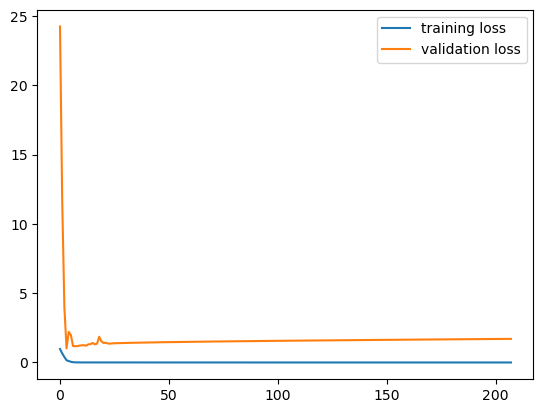

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
cd16
4560


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1587 loss_val: 1.2553 time: 8.1392s
 Epoch: 0010 loss_train: 0.0266 loss_val: 1.7287 time: 4.9153s
 Epoch: 0020 loss_train: 0.0051 loss_val: 1.8265 time: 5.5947s
 Epoch: 0030 loss_train: 0.0045 loss_val: 1.9297 time: 8.5379s
 Epoch: 0040 loss_train: 0.0019 loss_val: 1.9534 time: 8.3385s
 Epoch: 0050 loss_train: 0.0030 loss_val: 1.9912 time: 9.0769s
 Epoch: 0060 loss_train: 0.0034 loss_val: 2.0444 time: 7.2182s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.0929 time: 7.0405s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.1343 time: 8.8872s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.1604 time: 8.1914s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.1891 time: 8.4528s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.2082 time: 8.6027s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.2314 time: 7.7581s
 Epoch: 0130 loss_train: 0.0100 loss_val: 2.3303 time: 8.0224s
 Epoch: 0140 loss_train: 0.0061 loss_val: 2.1415 time: 8.3283s
 Epoch: 0150 loss_train: 0.0042 loss_val: 2.2636 time: 

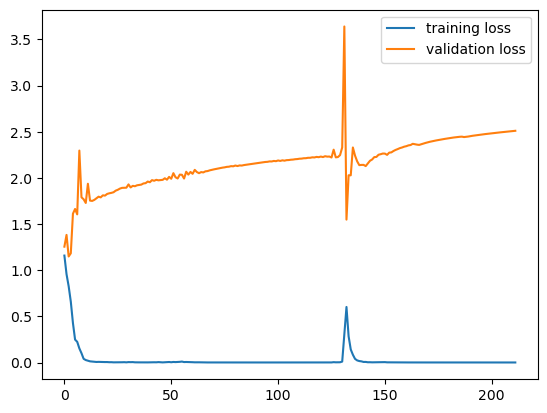

cd3
3772


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0131 loss_val: 1.2833 time: 7.3427s
 Epoch: 0010 loss_train: 0.0087 loss_val: 1.2790 time: 7.4872s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.2607 time: 7.6210s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2934 time: 8.3904s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3206 time: 7.1425s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3437 time: 8.0046s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3642 time: 6.6155s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3826 time: 7.8566s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3995 time: 6.9413s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4151 time: 6.6860s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4297 time: 6.7185s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4436 time: 8.1410s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4568 time: 7.1095s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4694 time: 6.9934s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4815 time: 7.4234s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4933 time: 

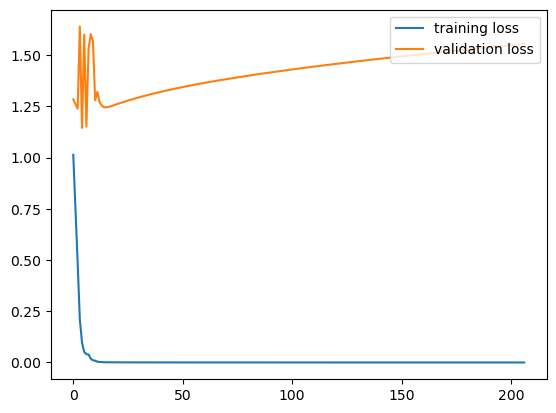

cd4
5602


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1647 loss_val: 10.9578 time: 8.3411s
 Epoch: 0010 loss_train: 0.0313 loss_val: 1.9182 time: 10.2862s
 Epoch: 0020 loss_train: 0.0036 loss_val: 1.8253 time: 9.9487s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.8596 time: 8.0882s
 Epoch: 0040 loss_train: 0.0006 loss_val: 1.9094 time: 10.3153s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.9483 time: 10.1518s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.9760 time: 8.1904s
 Epoch: 0070 loss_train: 0.0004 loss_val: 2.0102 time: 10.7059s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.0359 time: 9.7661s
 Epoch: 0090 loss_train: 0.0340 loss_val: 2.1659 time: 9.1418s
 Epoch: 0100 loss_train: 0.0021 loss_val: 2.0063 time: 6.9939s
 Epoch: 0110 loss_train: 0.0014 loss_val: 2.1237 time: 9.9952s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.1633 time: 10.5667s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.2049 time: 9.9791s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.2358 time: 8.7243s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.2617 

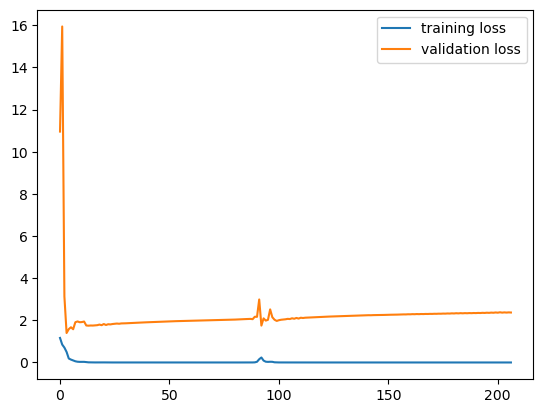

cd8
5625


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9921 loss_val: 36.0840 time: 9.7682s
 Epoch: 0010 loss_train: 0.0160 loss_val: 1.5846 time: 10.7573s
 Epoch: 0020 loss_train: 0.0032 loss_val: 1.6524 time: 9.6982s
 Epoch: 0030 loss_train: 0.0036 loss_val: 1.7303 time: 11.6823s
 Epoch: 0040 loss_train: 0.0012 loss_val: 1.7994 time: 10.2114s
 Epoch: 0050 loss_train: 0.0021 loss_val: 1.8094 time: 11.6874s
 Epoch: 0060 loss_train: 0.0013 loss_val: 1.9654 time: 9.0103s
 Epoch: 0070 loss_train: 0.0013 loss_val: 1.9692 time: 8.5358s
 Epoch: 0080 loss_train: 0.0004 loss_val: 1.9845 time: 9.8477s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.0289 time: 9.3803s
 Epoch: 0100 loss_train: 0.0003 loss_val: 2.0320 time: 10.1633s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.0816 time: 8.9735s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.1136 time: 9.4128s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.1689 time: 8.7537s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.1611 time: 10.8072s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.3102

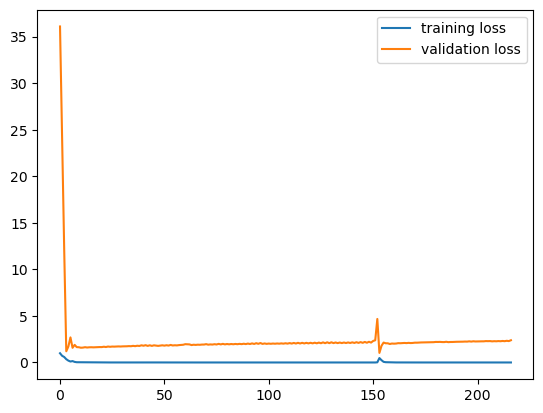

gh2ax
4892


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0508 loss_val: 5.4623 time: 6.9810s
 Epoch: 0010 loss_train: 0.0037 loss_val: 0.6974 time: 8.4682s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7388 time: 9.1124s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7650 time: 8.4546s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7860 time: 8.5841s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.8039 time: 8.8408s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8196 time: 8.4045s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8336 time: 8.4256s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8466 time: 7.3112s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8587 time: 7.7725s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8701 time: 8.4872s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8809 time: 7.7877s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8911 time: 8.0917s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9010 time: 7.9785s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9105 time: 7.9427s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9199 time: 

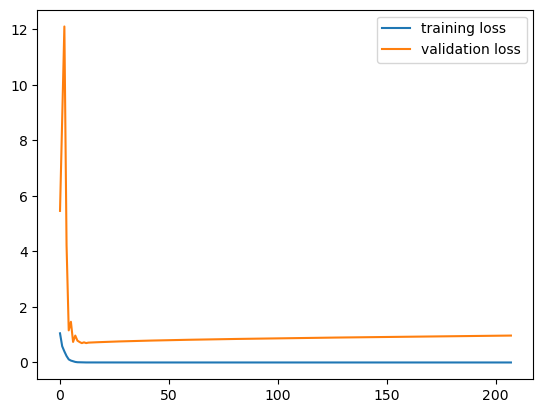

lamin
4893


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9633 loss_val: 23.1268 time: 9.4136s
 Epoch: 0010 loss_train: 0.0035 loss_val: 1.2005 time: 9.1362s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.2595 time: 8.0896s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.3050 time: 7.7635s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.3392 time: 8.9295s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3671 time: 9.1814s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.3911 time: 7.9611s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4121 time: 8.6868s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4314 time: 9.0491s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4490 time: 9.9629s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4655 time: 9.5354s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.4809 time: 8.2309s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.4957 time: 8.5027s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5099 time: 8.3999s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5235 time: 9.3596s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5368 time:

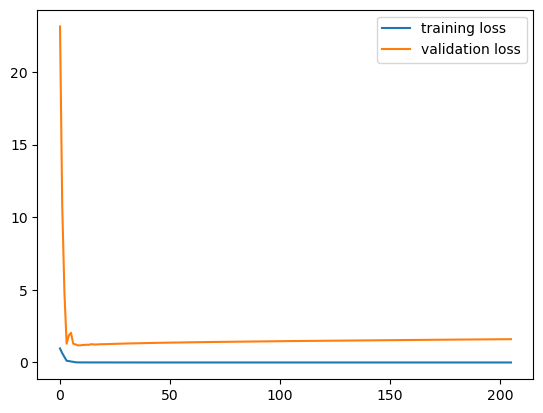

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
28
cd16
4544


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1266 loss_val: 1.3467 time: 7.3709s
 Epoch: 0010 loss_train: 0.0313 loss_val: 2.0133 time: 9.0777s
 Epoch: 0020 loss_train: 0.0072 loss_val: 1.9846 time: 7.4598s
 Epoch: 0030 loss_train: 0.0067 loss_val: 2.0126 time: 8.4795s
 Epoch: 0040 loss_train: 0.0039 loss_val: 2.1134 time: 8.4752s
 Epoch: 0050 loss_train: 0.0027 loss_val: 2.0988 time: 8.9597s
 Epoch: 0060 loss_train: 0.0031 loss_val: 2.2611 time: 9.4999s
 Epoch: 0070 loss_train: 0.0020 loss_val: 2.1687 time: 10.1216s
 Epoch: 0080 loss_train: 0.0082 loss_val: 2.6196 time: 7.7787s
 Epoch: 0090 loss_train: 0.0063 loss_val: 2.3239 time: 9.1779s
 Epoch: 0100 loss_train: 0.0020 loss_val: 2.2842 time: 8.3747s
 Epoch: 0110 loss_train: 0.0016 loss_val: 2.3114 time: 8.9560s
 Epoch: 0120 loss_train: 0.0014 loss_val: 2.3375 time: 9.2995s
 Epoch: 0130 loss_train: 0.0015 loss_val: 2.4482 time: 9.1582s
 Epoch: 0140 loss_train: 0.0013 loss_val: 2.3855 time: 8.2358s
 Epoch: 0150 loss_train: 0.0013 loss_val: 2.3969 time:

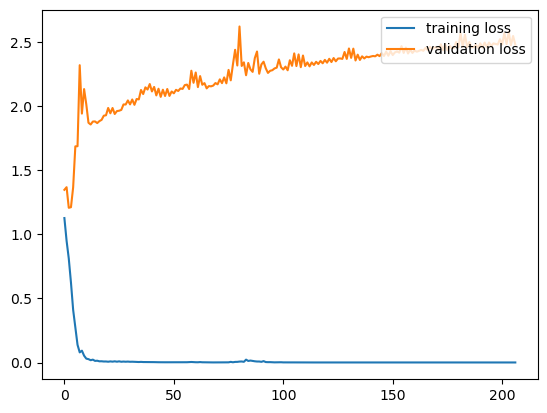

cd3
3781


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0340 loss_val: 1.1559 time: 7.8092s
 Epoch: 0010 loss_train: 0.0024 loss_val: 1.1845 time: 6.9828s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2179 time: 6.1274s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2574 time: 7.1411s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2879 time: 7.5240s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3133 time: 7.7436s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3351 time: 5.6997s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3543 time: 5.7144s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3718 time: 6.7556s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3879 time: 5.7758s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4028 time: 6.6276s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4167 time: 6.5083s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4301 time: 6.4718s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4428 time: 5.3744s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4549 time: 7.4125s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4665 time: 

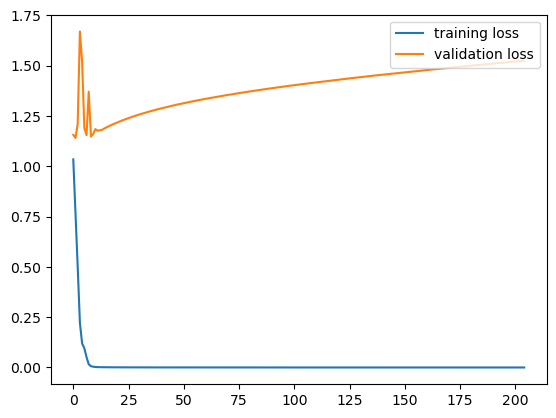

cd4
5579


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1697 loss_val: 10.5323 time: 12.1107s
 Epoch: 0010 loss_train: 0.0498 loss_val: 2.4608 time: 9.1676s
 Epoch: 0020 loss_train: 0.0014 loss_val: 2.0744 time: 9.7880s
 Epoch: 0030 loss_train: 0.0024 loss_val: 2.1608 time: 10.8065s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.1899 time: 9.1525s
 Epoch: 0050 loss_train: 0.0005 loss_val: 2.2486 time: 9.6645s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.2933 time: 10.3154s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.3317 time: 10.4259s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.3644 time: 9.7066s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3958 time: 10.3759s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4239 time: 10.4752s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4502 time: 11.1789s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4750 time: 11.1394s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.4984 time: 10.3203s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.5210 time: 9.3350s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.5

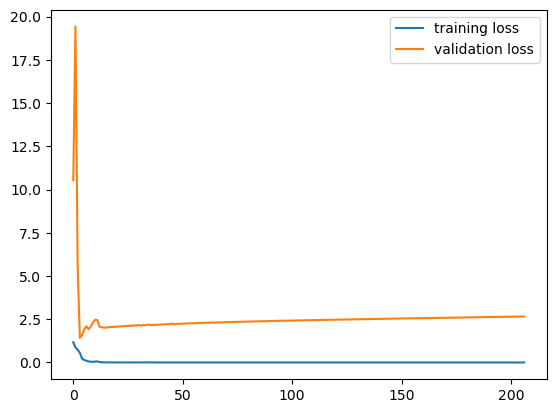

cd8
5605


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9691 loss_val: 43.3703 time: 10.1578s
 Epoch: 0010 loss_train: 0.0136 loss_val: 1.6545 time: 9.9085s
 Epoch: 0020 loss_train: 0.0047 loss_val: 1.6840 time: 8.1017s
 Epoch: 0030 loss_train: 0.0019 loss_val: 1.7359 time: 10.6060s
 Epoch: 0040 loss_train: 0.0033 loss_val: 1.8276 time: 10.0586s
 Epoch: 0050 loss_train: 0.0009 loss_val: 1.8453 time: 9.4274s
 Epoch: 0060 loss_train: 0.0005 loss_val: 1.8846 time: 9.4297s
 Epoch: 0070 loss_train: 0.0005 loss_val: 1.9194 time: 8.7177s
 Epoch: 0080 loss_train: 0.0004 loss_val: 1.9452 time: 9.9160s
 Epoch: 0090 loss_train: 0.0004 loss_val: 1.9772 time: 9.6362s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.0058 time: 8.5741s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.0234 time: 9.5044s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.0529 time: 9.1149s
 Epoch: 0130 loss_train: 0.5407 loss_val: 1.2871 time: 9.8730s
 Epoch: 0140 loss_train: 0.0032 loss_val: 2.0347 time: 8.7838s
 Epoch: 0150 loss_train: 0.0029 loss_val: 2.1494 ti

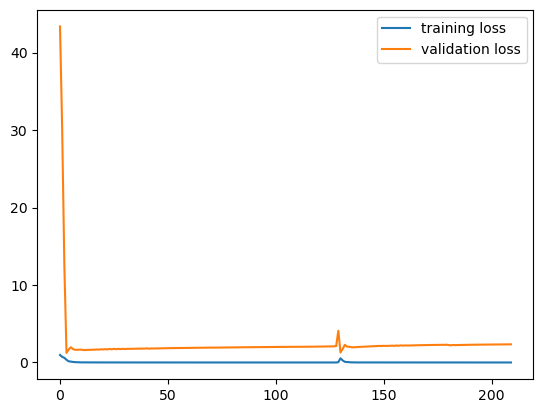

gh2ax
4926


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0075 loss_val: 5.6668 time: 7.9453s
 Epoch: 0010 loss_train: 0.0036 loss_val: 0.7266 time: 8.8525s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7512 time: 8.8114s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7770 time: 8.5838s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7981 time: 7.8057s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.8158 time: 8.2619s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8312 time: 9.1024s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8451 time: 8.3200s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8578 time: 7.5202s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8695 time: 9.7420s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8803 time: 8.6805s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8908 time: 7.6303s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.9010 time: 8.2519s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9105 time: 7.9496s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9199 time: 7.2578s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9287 time: 

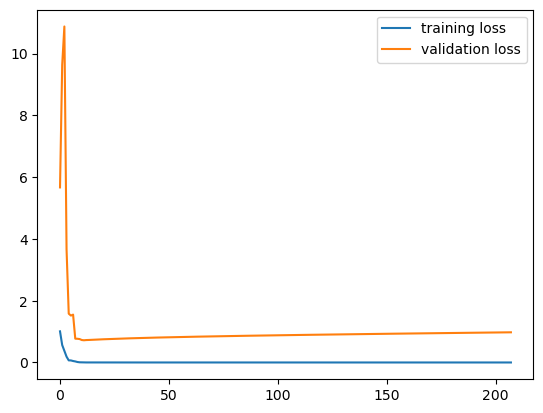

lamin
4927


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9754 loss_val: 24.4991 time: 8.2238s
 Epoch: 0010 loss_train: 0.0060 loss_val: 1.3998 time: 7.6842s
 Epoch: 0020 loss_train: 0.0018 loss_val: 1.4355 time: 7.3794s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.4820 time: 8.1524s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.5113 time: 8.3442s
 Epoch: 0050 loss_train: 0.0001 loss_val: 1.5362 time: 7.5523s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.5586 time: 8.5737s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5785 time: 8.8377s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5970 time: 8.8660s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6143 time: 7.9122s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6309 time: 9.2038s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.6465 time: 6.6834s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.6616 time: 8.4406s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6760 time: 7.3430s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6900 time: 8.0824s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7038 time:

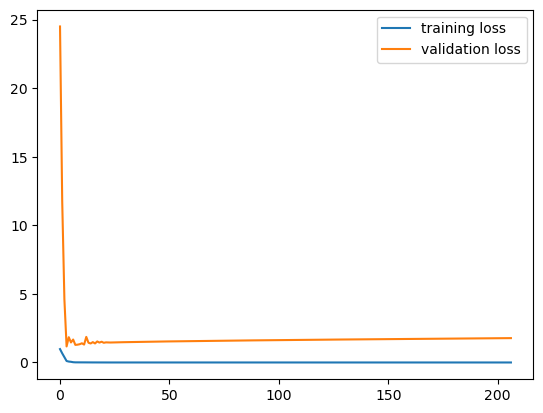

29
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
29
cd16
4608


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1335 loss_val: 1.2600 time: 8.2931s
 Epoch: 0010 loss_train: 0.0178 loss_val: 1.8426 time: 8.1566s
 Epoch: 0020 loss_train: 0.0055 loss_val: 1.9483 time: 7.3273s
 Epoch: 0030 loss_train: 0.0031 loss_val: 2.0951 time: 7.9057s
 Epoch: 0040 loss_train: 0.0039 loss_val: 2.1256 time: 8.3445s
 Epoch: 0050 loss_train: 0.0018 loss_val: 2.1523 time: 8.2807s
 Epoch: 0060 loss_train: 0.0009 loss_val: 2.1967 time: 7.8000s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.2450 time: 8.2253s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.2694 time: 8.7440s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.3050 time: 8.1701s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.3415 time: 9.0971s
 Epoch: 0110 loss_train: 0.0009 loss_val: 2.5316 time: 9.1815s
 Epoch: 0120 loss_train: 0.0124 loss_val: 2.3301 time: 6.8051s
 Epoch: 0130 loss_train: 0.0021 loss_val: 2.3042 time: 8.2688s
 Epoch: 0140 loss_train: 0.0013 loss_val: 2.3578 time: 6.8639s
 Epoch: 0150 loss_train: 0.0007 loss_val: 2.4094 time: 

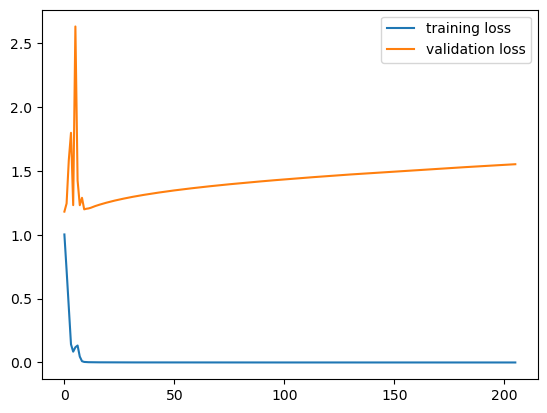

cd4
5637


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1299 loss_val: 20.1872 time: 8.8246s
 Epoch: 0010 loss_train: 0.0095 loss_val: 1.6462 time: 8.9503s
 Epoch: 0020 loss_train: 0.0021 loss_val: 1.7556 time: 10.4142s
 Epoch: 0030 loss_train: 0.0020 loss_val: 1.8232 time: 8.6521s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.8801 time: 9.7590s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.9217 time: 8.8496s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.9556 time: 9.8566s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.9853 time: 10.0847s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.0125 time: 11.8220s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0376 time: 6.8554s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0613 time: 10.7803s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.0835 time: 8.6370s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.1052 time: 8.8127s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.1259 time: 9.0301s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.1464 time: 9.7913s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.1659 t

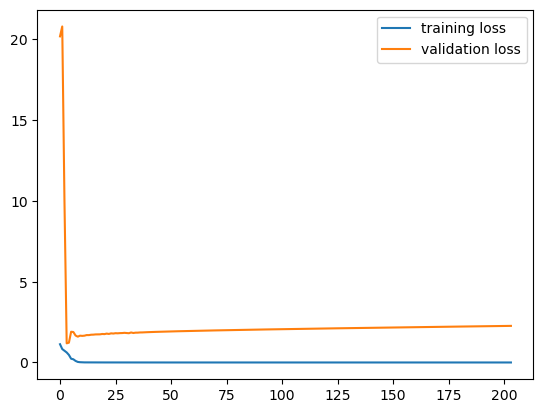

cd8
5659


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9691 loss_val: 54.8451 time: 7.4230s
 Epoch: 0010 loss_train: 0.0186 loss_val: 1.5740 time: 9.6964s
 Epoch: 0020 loss_train: 0.0027 loss_val: 1.6812 time: 8.4188s
 Epoch: 0030 loss_train: 0.0031 loss_val: 1.7551 time: 10.0295s
 Epoch: 0040 loss_train: 0.0016 loss_val: 1.7921 time: 11.2342s
 Epoch: 0050 loss_train: 0.0054 loss_val: 1.8252 time: 11.1497s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.8596 time: 9.9956s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.8935 time: 10.5028s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.9218 time: 10.9229s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.9466 time: 10.4698s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.9690 time: 10.8762s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.9899 time: 11.1870s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.0096 time: 11.1340s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.0286 time: 10.0347s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.0467 time: 9.1311s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.

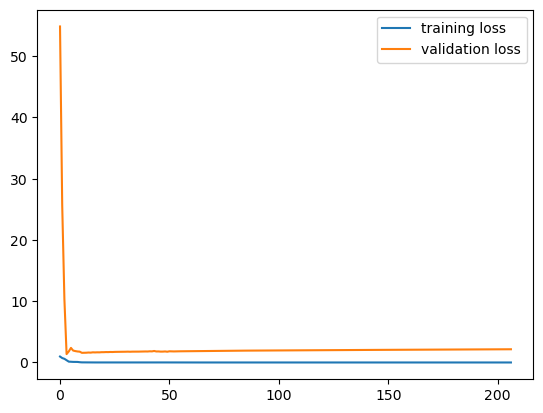

gh2ax
4938


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9998 loss_val: 5.9685 time: 11.2739s
 Epoch: 0010 loss_train: 0.0043 loss_val: 0.7553 time: 9.6730s
 Epoch: 0020 loss_train: 0.0005 loss_val: 0.7601 time: 11.5564s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7840 time: 10.9601s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.8040 time: 10.8972s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.8211 time: 10.7054s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8365 time: 10.5724s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8505 time: 9.6227s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8633 time: 9.6876s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8753 time: 8.3884s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8866 time: 9.1214s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8973 time: 10.1403s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.9076 time: 8.2417s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9174 time: 9.7484s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9269 time: 10.2721s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.936

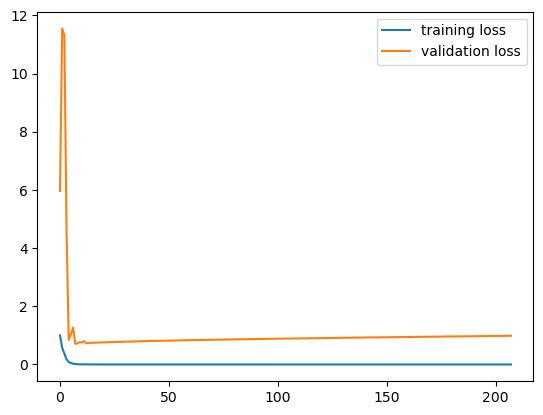

lamin
4939


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9732 loss_val: 24.6211 time: 8.3081s
 Epoch: 0010 loss_train: 0.0038 loss_val: 1.3498 time: 9.2749s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.4255 time: 8.3300s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.4653 time: 9.1668s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4972 time: 10.2073s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.5237 time: 9.0024s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.5472 time: 9.7438s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5682 time: 9.7414s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5876 time: 10.4989s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6056 time: 9.8833s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6225 time: 9.9838s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6386 time: 9.4360s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.6540 time: 9.8387s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6687 time: 9.4107s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6829 time: 10.4942s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6968 ti

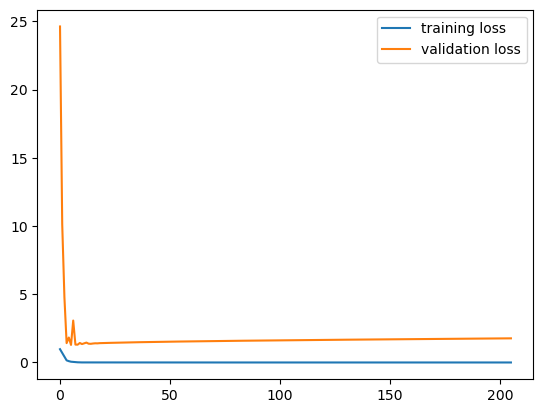

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
cd16
4555


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1356 loss_val: 1.1442 time: 8.2884s
 Epoch: 0010 loss_train: 0.0207 loss_val: 2.3526 time: 8.3299s
 Epoch: 0020 loss_train: 0.0056 loss_val: 1.9262 time: 8.6996s
 Epoch: 0030 loss_train: 0.0036 loss_val: 2.0152 time: 10.3546s
 Epoch: 0040 loss_train: 0.0030 loss_val: 2.0558 time: 10.1574s
 Epoch: 0050 loss_train: 0.0013 loss_val: 2.0863 time: 10.9572s
 Epoch: 0060 loss_train: 0.0012 loss_val: 2.1288 time: 10.6775s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.1631 time: 10.5393s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.1865 time: 10.0613s
 Epoch: 0090 loss_train: 0.0010 loss_val: 2.2173 time: 10.9014s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.2407 time: 9.9660s
 Epoch: 0110 loss_train: 0.0064 loss_val: 2.3681 time: 9.6859s
 Epoch: 0120 loss_train: 0.0208 loss_val: 2.4424 time: 7.2392s
 Epoch: 0130 loss_train: 0.0031 loss_val: 2.2673 time: 9.3638s
 Epoch: 0140 loss_train: 0.0010 loss_val: 2.3289 time: 8.4247s
 Epoch: 0150 loss_train: 0.0009 loss_val: 2.3843

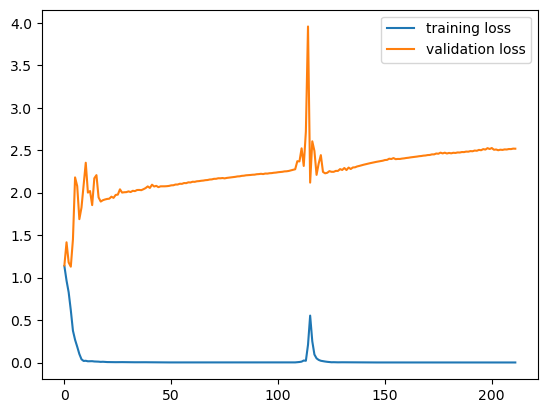

cd3
3760


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0050 loss_val: 1.3006 time: 7.6774s
 Epoch: 0010 loss_train: 0.0132 loss_val: 1.7902 time: 8.4204s
 Epoch: 0020 loss_train: 0.0157 loss_val: 1.6571 time: 7.0801s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.4561 time: 7.0952s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.4679 time: 7.3055s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4801 time: 9.0053s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4922 time: 8.1214s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5038 time: 8.9940s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5149 time: 6.8868s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5253 time: 6.1577s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5356 time: 7.6540s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5455 time: 8.1303s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5550 time: 7.4825s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5645 time: 8.1144s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5737 time: 7.6374s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5827 time: 

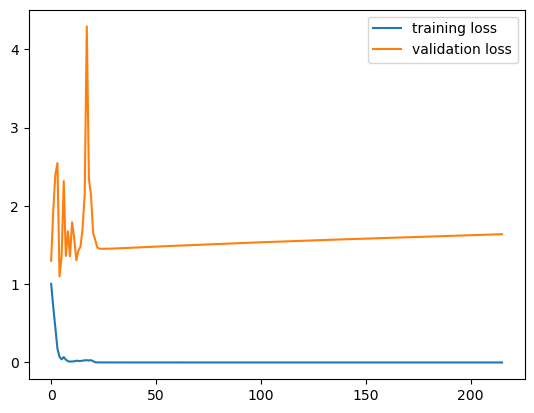

cd4
5580


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1432 loss_val: 14.7265 time: 9.6857s
 Epoch: 0010 loss_train: 0.0319 loss_val: 1.8762 time: 10.4009s
 Epoch: 0020 loss_train: 0.0050 loss_val: 1.9212 time: 11.4769s
 Epoch: 0030 loss_train: 0.0022 loss_val: 1.9830 time: 10.6436s
 Epoch: 0040 loss_train: 0.0017 loss_val: 2.0340 time: 11.9424s
 Epoch: 0050 loss_train: 0.0018 loss_val: 2.0786 time: 10.3142s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1329 time: 8.0639s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1737 time: 10.9662s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.2070 time: 8.9298s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2361 time: 9.8068s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2623 time: 10.3026s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2867 time: 10.4819s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3097 time: 9.1546s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.3315 time: 10.8368s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.3527 time: 12.2530s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.

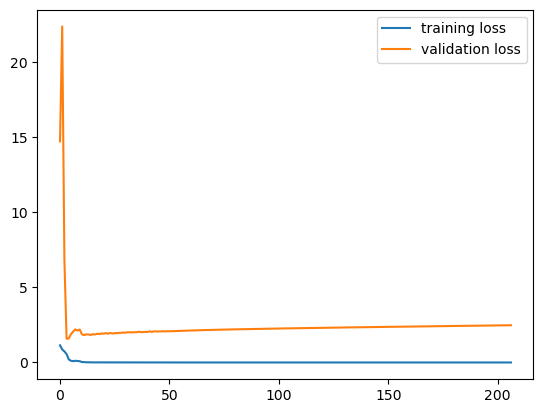

cd8
5604


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9719 loss_val: 45.5297 time: 10.9453s
 Epoch: 0010 loss_train: 0.0132 loss_val: 1.8444 time: 11.8871s
 Epoch: 0020 loss_train: 0.0041 loss_val: 1.7500 time: 10.2171s
 Epoch: 0030 loss_train: 0.0021 loss_val: 1.8149 time: 10.9222s
 Epoch: 0040 loss_train: 0.0019 loss_val: 1.8827 time: 9.2674s
 Epoch: 0050 loss_train: 0.0016 loss_val: 1.9210 time: 10.7970s
 Epoch: 0060 loss_train: 0.0054 loss_val: 2.1777 time: 9.9098s
 Epoch: 0070 loss_train: 0.0060 loss_val: 1.8060 time: 9.3003s
 Epoch: 0080 loss_train: 0.0020 loss_val: 1.9186 time: 10.9359s
 Epoch: 0090 loss_train: 0.0015 loss_val: 1.9777 time: 10.1854s
 Epoch: 0100 loss_train: 0.0012 loss_val: 2.0179 time: 12.2558s
 Epoch: 0110 loss_train: 0.0012 loss_val: 2.0490 time: 10.7119s
 Epoch: 0120 loss_train: 0.0014 loss_val: 2.0812 time: 10.5702s
 Epoch: 0130 loss_train: 0.0024 loss_val: 2.0596 time: 11.7244s
 Epoch: 0140 loss_train: 0.0017 loss_val: 2.0876 time: 12.3518s
 Epoch: 0150 loss_train: 0.0016 loss_val: 

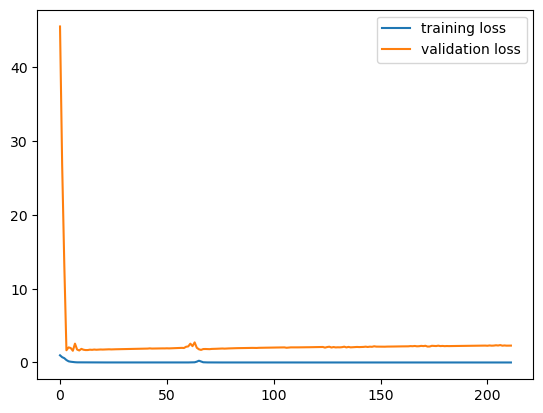

gh2ax
4837


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9930 loss_val: 6.3058 time: 9.5052s
 Epoch: 0010 loss_train: 0.0026 loss_val: 0.5826 time: 10.8587s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.5977 time: 11.4223s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.6210 time: 10.7275s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.6390 time: 10.1514s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.6541 time: 8.7589s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.6674 time: 11.1120s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.6792 time: 9.0124s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.6900 time: 10.0800s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.7000 time: 9.5536s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.7094 time: 9.9698s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.7183 time: 9.1793s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.7267 time: 8.8014s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.7348 time: 10.0005s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.7426 time: 10.3787s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.750

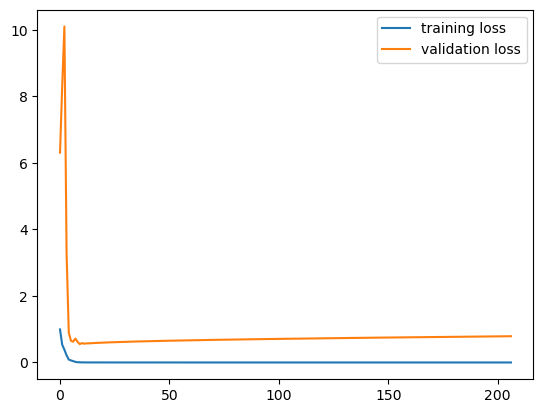

lamin
4838


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9201 loss_val: 20.7687 time: 8.6222s
 Epoch: 0010 loss_train: 0.0023 loss_val: 1.0754 time: 8.3492s
 Epoch: 0020 loss_train: 0.0036 loss_val: 1.3255 time: 8.7279s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.2437 time: 11.8008s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.2684 time: 8.6060s
 Epoch: 0050 loss_train: 0.0001 loss_val: 1.2897 time: 10.7279s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.3084 time: 9.0525s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3253 time: 9.8300s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3410 time: 10.5749s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3555 time: 9.5037s
 Epoch: 0100 loss_train: 0.0000 loss_val: 1.3694 time: 9.9332s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.3826 time: 10.6461s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.3951 time: 10.7749s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.4072 time: 9.8749s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4189 time: 10.0602s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4304

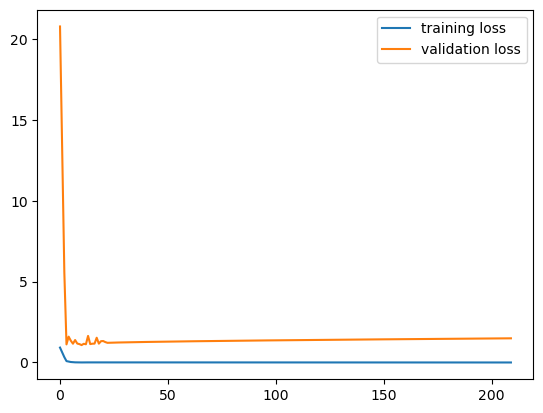

31
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
31
cd16
4490


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1403 loss_val: 1.5102 time: 10.1462s
 Epoch: 0010 loss_train: 0.0121 loss_val: 1.7510 time: 9.9100s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.8023 time: 10.9403s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.8582 time: 11.3378s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.9006 time: 9.7832s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.9358 time: 9.3720s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.9661 time: 11.1400s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.9931 time: 10.8696s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.0177 time: 10.2636s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0404 time: 10.1675s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0614 time: 9.9717s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.0813 time: 10.0007s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.1003 time: 9.1192s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.1184 time: 10.6992s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.1358 time: 10.3861s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.1

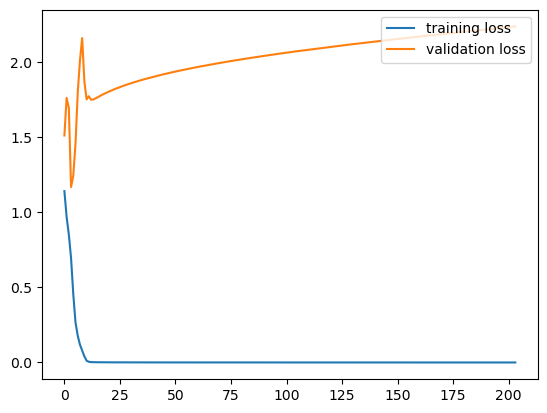

cd3
3802


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9665 loss_val: 1.2729 time: 7.5445s
 Epoch: 0010 loss_train: 0.0129 loss_val: 1.1292 time: 4.4068s
 Epoch: 0020 loss_train: 0.0965 loss_val: 1.8806 time: 7.2525s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.2671 time: 8.6204s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2800 time: 7.2870s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2931 time: 7.4224s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3054 time: 6.5371s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3171 time: 7.7669s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3280 time: 7.1661s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3385 time: 7.4052s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3484 time: 7.8794s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3581 time: 7.1793s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3674 time: 7.3753s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3764 time: 6.1640s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3853 time: 6.8726s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3939 time: 

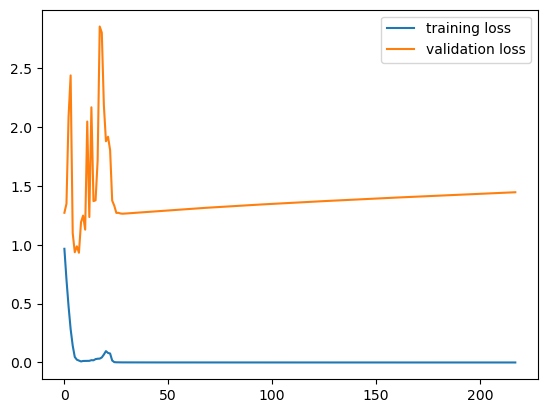

cd4
5518


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1643 loss_val: 14.2120 time: 11.3867s
 Epoch: 0010 loss_train: 0.0142 loss_val: 2.0585 time: 10.6010s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.9346 time: 10.8366s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.9838 time: 11.3017s
 Epoch: 0040 loss_train: 0.0002 loss_val: 2.0242 time: 9.2264s
 Epoch: 0050 loss_train: 0.0002 loss_val: 2.0589 time: 10.6944s
 Epoch: 0060 loss_train: 0.0001 loss_val: 2.0897 time: 9.8253s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.1175 time: 8.6454s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.1433 time: 11.7466s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1674 time: 10.8973s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1902 time: 11.5589s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2119 time: 10.4322s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.2328 time: 9.1156s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.2531 time: 9.2982s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.2728 time: 11.3710s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.

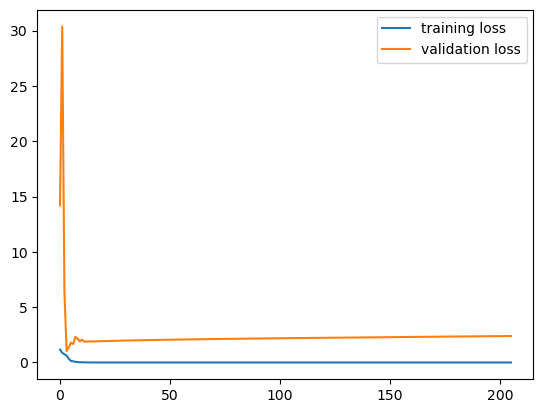

cd8
5545


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0142 loss_val: 38.8537 time: 10.1806s
 Epoch: 0010 loss_train: 0.0101 loss_val: 1.9760 time: 9.8052s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.8371 time: 10.6130s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.8849 time: 11.0874s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.9237 time: 10.0173s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.9567 time: 11.2548s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.9863 time: 9.1169s
 Epoch: 0070 loss_train: 0.0001 loss_val: 2.0129 time: 10.5979s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.0375 time: 9.8163s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0605 time: 9.3135s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0821 time: 9.6358s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1029 time: 9.1893s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.1226 time: 9.3343s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.1417 time: 10.1180s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.1603 time: 10.6675s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.17

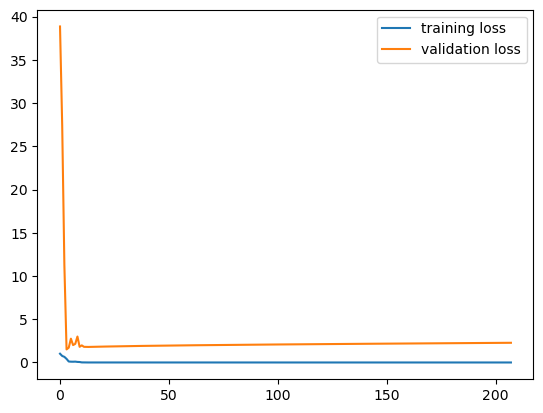

gh2ax
4931


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9557 loss_val: 6.0875 time: 9.1671s
 Epoch: 0010 loss_train: 0.0049 loss_val: 0.6099 time: 9.1725s
 Epoch: 0020 loss_train: 0.0005 loss_val: 0.6639 time: 8.7005s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.6927 time: 9.7636s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7147 time: 8.9033s
 Epoch: 0050 loss_train: 0.0001 loss_val: 0.7331 time: 9.2859s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7490 time: 8.5617s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7631 time: 8.8066s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.7759 time: 8.8462s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.7879 time: 8.9427s
 Epoch: 0100 loss_train: 0.0000 loss_val: 0.7991 time: 8.9348s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8097 time: 7.9044s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8198 time: 8.9160s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8295 time: 6.5551s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8387 time: 8.2616s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8478 time: 

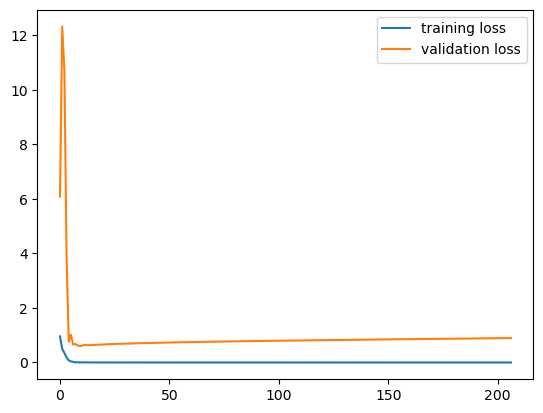

lamin
4932


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9794 loss_val: 24.1630 time: 8.0169s
 Epoch: 0010 loss_train: 0.0030 loss_val: 1.2211 time: 8.1239s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.3010 time: 9.2797s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3452 time: 9.6697s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.3784 time: 9.1159s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4060 time: 9.1451s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4296 time: 7.6638s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4507 time: 9.2377s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4699 time: 10.4562s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4877 time: 9.1960s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5043 time: 7.6568s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5200 time: 9.7345s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.5352 time: 9.1689s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5494 time: 8.4139s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5635 time: 8.1278s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5771 time

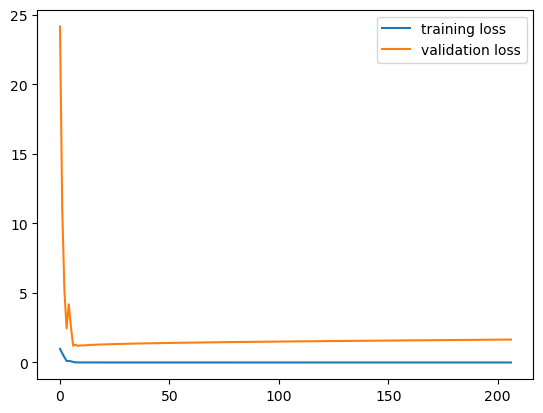

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
cd16
4629


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1349 loss_val: 1.2020 time: 9.3264s
 Epoch: 0010 loss_train: 0.0196 loss_val: 2.0033 time: 8.9541s
 Epoch: 0020 loss_train: 0.0067 loss_val: 1.9201 time: 8.5925s
 Epoch: 0030 loss_train: 0.0019 loss_val: 1.9985 time: 9.5551s
 Epoch: 0040 loss_train: 0.0047 loss_val: 2.0443 time: 8.9164s
 Epoch: 0050 loss_train: 0.0005 loss_val: 2.1077 time: 9.2053s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1555 time: 9.0005s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1940 time: 7.9718s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2273 time: 8.4039s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2567 time: 9.3299s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2839 time: 9.5206s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3090 time: 9.4552s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3325 time: 9.4831s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3549 time: 8.7643s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3763 time: 9.8978s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3969 time: 

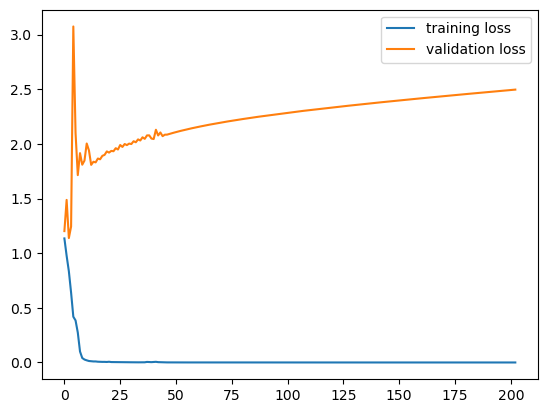

cd3
3806


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9839 loss_val: 1.1228 time: 7.7027s
 Epoch: 0010 loss_train: 0.0045 loss_val: 1.2459 time: 7.6431s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.3243 time: 7.9661s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.3611 time: 7.0957s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3903 time: 7.9101s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4145 time: 7.5786s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4357 time: 8.2686s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4544 time: 7.5181s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4715 time: 8.1761s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4874 time: 7.8013s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5021 time: 7.9705s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5160 time: 7.4408s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5291 time: 7.9150s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5416 time: 7.2619s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5537 time: 5.5812s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5655 time: 

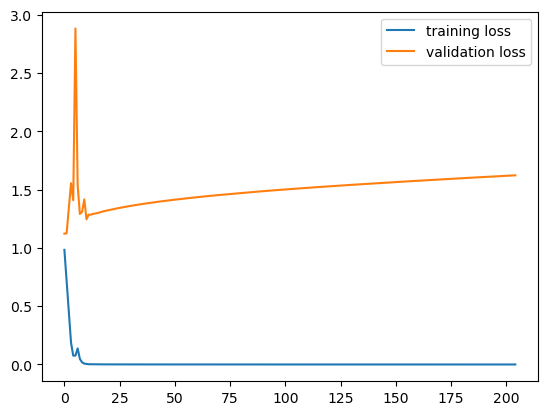

cd4
5663


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1640 loss_val: 24.8110 time: 9.9050s
 Epoch: 0010 loss_train: 0.0170 loss_val: 1.8781 time: 10.9267s
 Epoch: 0020 loss_train: 0.0074 loss_val: 2.3883 time: 8.0019s
 Epoch: 0030 loss_train: 0.0067 loss_val: 2.2668 time: 9.2896s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.2545 time: 11.0938s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.2911 time: 10.9717s
 Epoch: 0060 loss_train: 0.0005 loss_val: 2.3229 time: 11.1501s
 Epoch: 0070 loss_train: 0.0004 loss_val: 2.3500 time: 10.0981s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.3739 time: 8.4292s
 Epoch: 0090 loss_train: 0.0003 loss_val: 2.3980 time: 10.0246s
 Epoch: 0100 loss_train: 0.0003 loss_val: 2.4198 time: 10.5705s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.4419 time: 10.7227s
 Epoch: 0120 loss_train: 0.2820 loss_val: 1.8089 time: 11.1387s
 Epoch: 0130 loss_train: 0.0022 loss_val: 2.3151 time: 11.1510s
 Epoch: 0140 loss_train: 0.0009 loss_val: 2.3577 time: 10.1554s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2

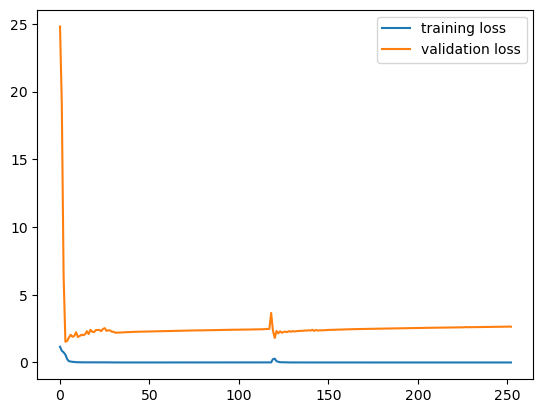

cd8
5687


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9889 loss_val: 52.5620 time: 11.8662s
 Epoch: 0010 loss_train: 0.0141 loss_val: 1.8010 time: 10.5294s
 Epoch: 0020 loss_train: 0.0019 loss_val: 1.7598 time: 11.9274s
 Epoch: 0030 loss_train: 0.0014 loss_val: 1.8299 time: 11.2466s
 Epoch: 0040 loss_train: 0.0009 loss_val: 1.8807 time: 11.3613s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.9371 time: 12.5629s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.9627 time: 10.5506s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.9996 time: 11.6951s
 Epoch: 0080 loss_train: 0.0003 loss_val: 2.0376 time: 10.7819s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0555 time: 10.2072s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.0812 time: 11.1701s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1050 time: 12.4989s
 Epoch: 0120 loss_train: 0.0000 loss_val: 2.1274 time: 9.8609s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.1486 time: 10.7402s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.1692 time: 11.2465s
 Epoch: 0150 loss_train: 0.0000 loss_val

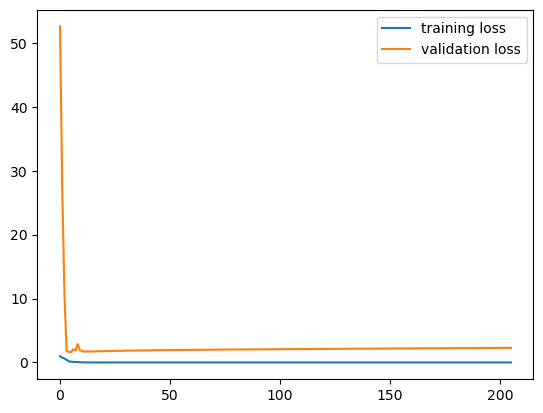

gh2ax
4889


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0301 loss_val: 5.6138 time: 7.8389s
 Epoch: 0010 loss_train: 0.0112 loss_val: 0.9097 time: 8.6921s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7036 time: 7.0995s
 Epoch: 0030 loss_train: 0.0004 loss_val: 0.7216 time: 8.9171s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7371 time: 9.5332s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.7508 time: 9.2325s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7632 time: 8.7637s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7747 time: 9.7096s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.7853 time: 8.6857s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.7954 time: 7.8860s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8049 time: 8.4028s
 Epoch: 0110 loss_train: 0.0001 loss_val: 0.8141 time: 8.4917s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8228 time: 8.4865s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8311 time: 9.7321s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8394 time: 9.3208s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8473 time: 

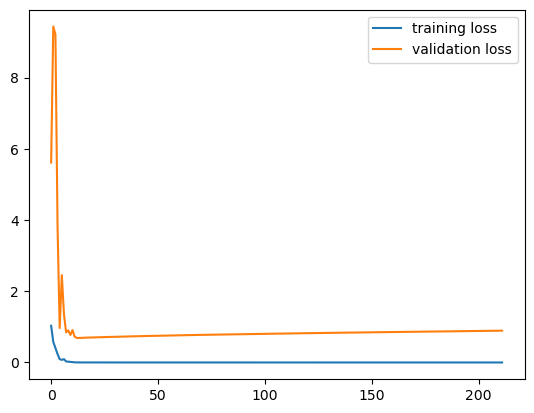

lamin
4890


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9512 loss_val: 27.9864 time: 8.3887s
 Epoch: 0010 loss_train: 0.0052 loss_val: 1.2138 time: 8.1765s
 Epoch: 0020 loss_train: 0.0012 loss_val: 1.3596 time: 8.2964s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.3762 time: 9.1356s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4054 time: 10.2547s
 Epoch: 0050 loss_train: 0.0001 loss_val: 1.4294 time: 8.5689s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4501 time: 9.5763s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4686 time: 8.0232s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4854 time: 8.5300s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5013 time: 9.9097s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5160 time: 7.7204s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.5301 time: 8.5324s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.5435 time: 8.8891s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5566 time: 9.1080s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5691 time: 8.5404s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5814 time

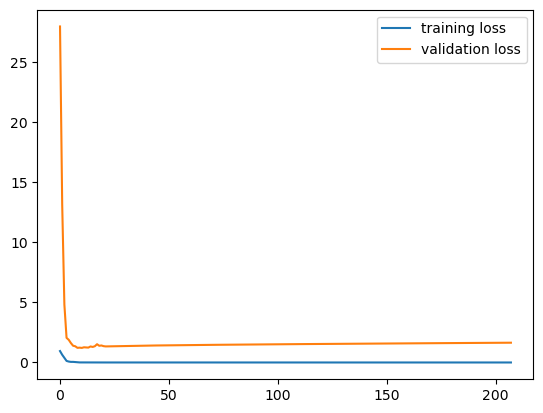

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
cd16
4560


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1514 loss_val: 1.1925 time: 8.3841s
 Epoch: 0010 loss_train: 0.0274 loss_val: 2.3457 time: 9.2664s
 Epoch: 0020 loss_train: 0.0064 loss_val: 1.8408 time: 7.7831s
 Epoch: 0030 loss_train: 0.0053 loss_val: 1.9076 time: 8.8506s
 Epoch: 0040 loss_train: 0.0029 loss_val: 1.9505 time: 10.4835s
 Epoch: 0050 loss_train: 0.0046 loss_val: 1.9977 time: 7.7500s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.0203 time: 7.7998s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.0710 time: 8.0716s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1075 time: 8.4043s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.1373 time: 7.8210s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1638 time: 8.5277s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1880 time: 8.0111s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2102 time: 9.1051s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2314 time: 7.5242s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2512 time: 8.7230s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2703 time:

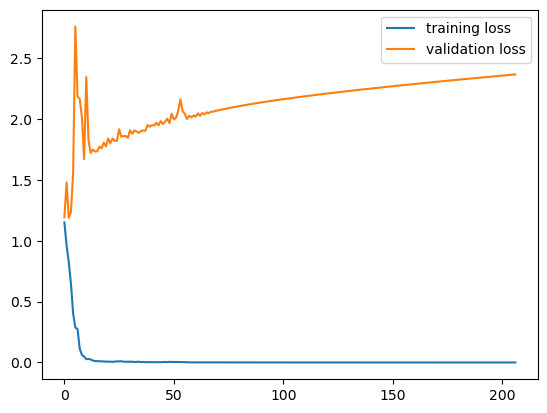

cd3
3772


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0002 loss_val: 1.1200 time: 8.7715s
 Epoch: 0010 loss_train: 0.0018 loss_val: 1.1935 time: 7.8819s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.2581 time: 6.7602s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.2975 time: 6.2708s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3286 time: 8.0435s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3545 time: 7.7752s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3768 time: 7.2119s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3966 time: 6.9404s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4146 time: 6.7035s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4314 time: 7.7085s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4468 time: 5.6143s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4614 time: 8.8894s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4751 time: 6.0445s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4883 time: 6.9898s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5009 time: 6.1140s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5133 time: 

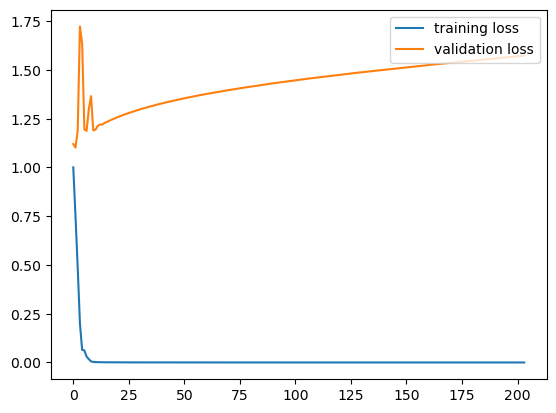

cd4
5602


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1646 loss_val: 12.2349 time: 8.7175s
 Epoch: 0010 loss_train: 0.0221 loss_val: 1.7388 time: 10.2872s
 Epoch: 0020 loss_train: 0.0058 loss_val: 1.7441 time: 11.2772s
 Epoch: 0030 loss_train: 0.0034 loss_val: 1.8249 time: 8.7569s
 Epoch: 0040 loss_train: 0.0034 loss_val: 1.8710 time: 10.8243s
 Epoch: 0050 loss_train: 0.0045 loss_val: 1.9344 time: 6.5368s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.9459 time: 8.9891s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.0066 time: 8.0860s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.0137 time: 11.2682s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.0685 time: 10.3433s
 Epoch: 0100 loss_train: 0.0003 loss_val: 2.0734 time: 9.0491s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.1134 time: 10.5991s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.1282 time: 8.0828s
 Epoch: 0130 loss_train: 0.0012 loss_val: 2.2359 time: 7.6575s
 Epoch: 0140 loss_train: 0.0058 loss_val: 1.9529 time: 10.5321s
 Epoch: 0150 loss_train: 0.0030 loss_val: 2.098

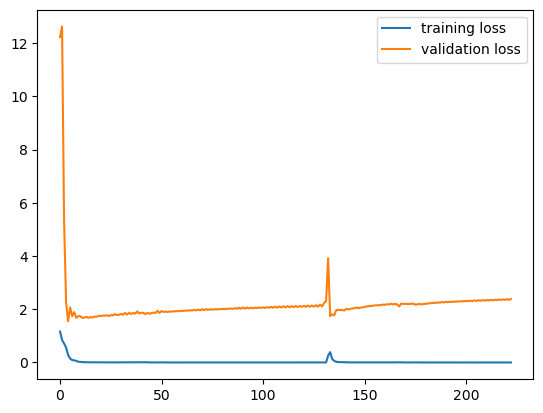

cd8
5625


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9779 loss_val: 37.8411 time: 10.2163s
 Epoch: 0010 loss_train: 0.0081 loss_val: 1.5847 time: 8.1946s
 Epoch: 0020 loss_train: 0.0028 loss_val: 1.6728 time: 8.3802s
 Epoch: 0030 loss_train: 0.0047 loss_val: 1.7335 time: 8.1770s
 Epoch: 0040 loss_train: 0.0016 loss_val: 1.8199 time: 7.7081s
 Epoch: 0050 loss_train: 0.0016 loss_val: 1.8933 time: 9.8620s
 Epoch: 0060 loss_train: 0.0040 loss_val: 1.9202 time: 8.9052s
 Epoch: 0070 loss_train: 0.0022 loss_val: 1.9599 time: 9.0583s
 Epoch: 0080 loss_train: 0.0005 loss_val: 1.9926 time: 7.5705s
 Epoch: 0090 loss_train: 0.0010 loss_val: 2.0447 time: 9.2328s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.0685 time: 9.4766s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.1172 time: 10.4613s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.1782 time: 9.5088s
 Epoch: 0130 loss_train: 0.0055 loss_val: 1.9300 time: 10.2212s
 Epoch: 0140 loss_train: 0.0013 loss_val: 2.0638 time: 9.3773s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.1364 ti

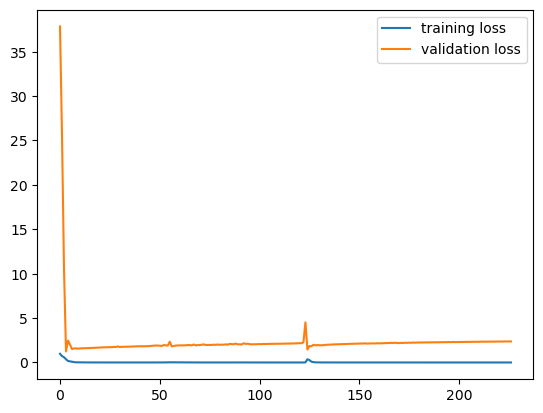

gh2ax
4892


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0313 loss_val: 6.0963 time: 9.2328s
 Epoch: 0010 loss_train: 0.0019 loss_val: 0.6982 time: 8.7234s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7384 time: 8.3211s
 Epoch: 0030 loss_train: 0.0004 loss_val: 0.7677 time: 7.9539s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7903 time: 8.8179s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.8093 time: 9.1574s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8259 time: 8.0186s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8406 time: 9.1022s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8540 time: 7.8290s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8665 time: 8.0739s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8780 time: 9.2902s
 Epoch: 0110 loss_train: 0.0001 loss_val: 0.8890 time: 9.1614s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8993 time: 7.6585s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9094 time: 8.6057s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9190 time: 9.7888s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9282 time: 

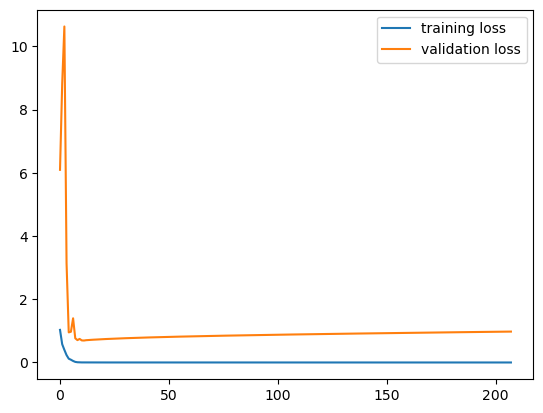

lamin
4893


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9603 loss_val: 24.5605 time: 9.1996s
 Epoch: 0010 loss_train: 0.0025 loss_val: 1.2888 time: 9.6460s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.3341 time: 8.4988s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.3751 time: 8.4486s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4079 time: 8.9019s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4354 time: 9.1081s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4592 time: 8.5548s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4806 time: 8.9623s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5002 time: 8.7496s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5184 time: 9.6437s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5353 time: 8.3879s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.5512 time: 7.6081s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.5665 time: 8.8024s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5812 time: 8.4118s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5953 time: 7.6729s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6090 time:

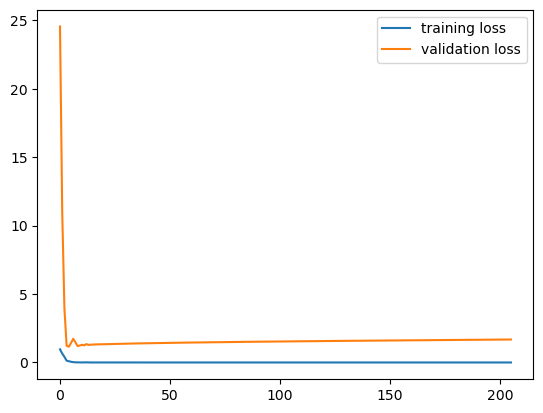

34
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
34
cd16
4544


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1406 loss_val: 1.2514 time: 7.6176s
 Epoch: 0010 loss_train: 0.0286 loss_val: 1.9631 time: 8.2750s
 Epoch: 0020 loss_train: 0.0062 loss_val: 1.8951 time: 7.5517s
 Epoch: 0030 loss_train: 0.0041 loss_val: 1.9781 time: 7.1042s
 Epoch: 0040 loss_train: 0.0046 loss_val: 2.0243 time: 7.5421s
 Epoch: 0050 loss_train: 0.0021 loss_val: 2.0699 time: 7.1907s
 Epoch: 0060 loss_train: 0.0009 loss_val: 2.1084 time: 7.0384s
 Epoch: 0070 loss_train: 0.0053 loss_val: 2.2243 time: 7.1807s
 Epoch: 0080 loss_train: 0.0095 loss_val: 2.4284 time: 7.9362s
 Epoch: 0090 loss_train: 0.0043 loss_val: 2.2324 time: 8.3697s
 Epoch: 0100 loss_train: 0.0019 loss_val: 2.3065 time: 8.7858s
 Epoch: 0110 loss_train: 0.0063 loss_val: 2.2522 time: 8.2961s
 Epoch: 0120 loss_train: 0.0264 loss_val: 2.3006 time: 6.9559s
 Epoch: 0130 loss_train: 0.0023 loss_val: 2.2593 time: 7.8107s
 Epoch: 0140 loss_train: 0.0017 loss_val: 2.3310 time: 6.9093s
 Epoch: 0150 loss_train: 0.0021 loss_val: 2.3683 time: 

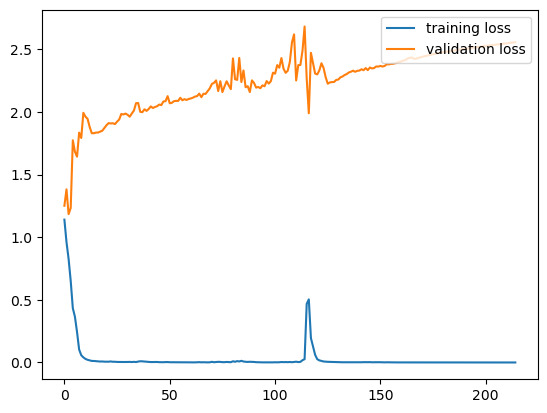

cd3
3781


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0448 loss_val: 1.1473 time: 7.1235s
 Epoch: 0010 loss_train: 0.0092 loss_val: 1.3564 time: 5.3553s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.3631 time: 6.4155s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3869 time: 6.2685s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.4092 time: 6.5019s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4293 time: 6.6983s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4474 time: 6.6557s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.4642 time: 6.8020s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4797 time: 4.9415s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4944 time: 6.5130s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5081 time: 6.6326s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5214 time: 6.4251s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5340 time: 6.8291s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5462 time: 7.0516s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5580 time: 6.7569s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5695 time: 

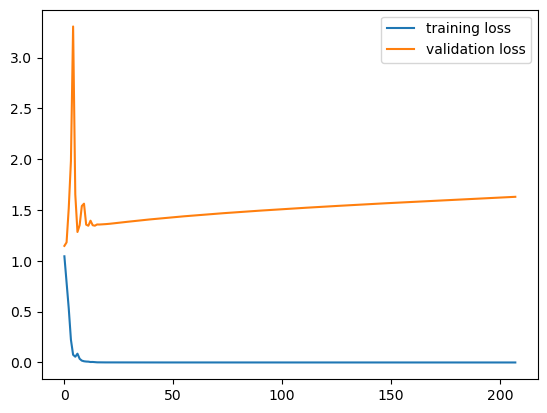

cd4
5579


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1790 loss_val: 12.8401 time: 10.0453s
 Epoch: 0010 loss_train: 0.0246 loss_val: 1.9993 time: 9.4594s
 Epoch: 0020 loss_train: 0.0043 loss_val: 1.9529 time: 9.1156s
 Epoch: 0030 loss_train: 0.0028 loss_val: 2.0118 time: 9.5482s
 Epoch: 0040 loss_train: 0.0027 loss_val: 2.0760 time: 9.0188s
 Epoch: 0050 loss_train: 0.0011 loss_val: 2.1413 time: 8.5651s
 Epoch: 0060 loss_train: 0.0024 loss_val: 2.1928 time: 9.0967s
 Epoch: 0070 loss_train: 0.0141 loss_val: 2.2580 time: 8.9587s
 Epoch: 0080 loss_train: 0.0030 loss_val: 2.3311 time: 8.8513s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.3289 time: 9.4976s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.3669 time: 9.6261s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.4031 time: 8.7641s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.4236 time: 9.2638s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.4469 time: 6.8475s
 Epoch: 0140 loss_train: 0.0077 loss_val: 2.8744 time: 8.8418s
 Epoch: 0150 loss_train: 0.0047 loss_val: 2.3529 time

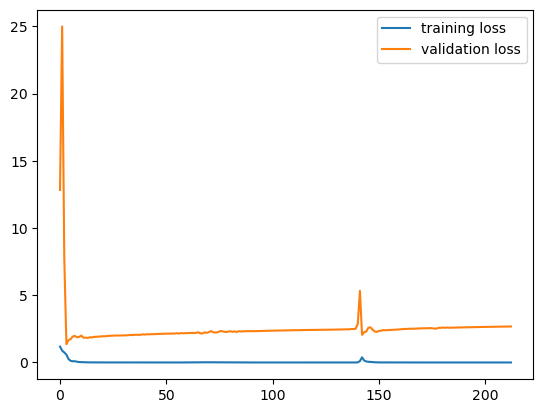

cd8
5605


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9842 loss_val: 47.1907 time: 8.7415s
 Epoch: 0010 loss_train: 0.0163 loss_val: 1.5581 time: 9.5141s
 Epoch: 0020 loss_train: 0.0063 loss_val: 1.6589 time: 8.3272s
 Epoch: 0030 loss_train: 0.0023 loss_val: 1.8008 time: 9.4548s
 Epoch: 0040 loss_train: 0.0052 loss_val: 1.7626 time: 8.9271s
 Epoch: 0050 loss_train: 0.0014 loss_val: 1.8228 time: 8.5479s
 Epoch: 0060 loss_train: 0.0005 loss_val: 1.8827 time: 9.1737s
 Epoch: 0070 loss_train: 0.0164 loss_val: 1.9511 time: 9.9902s
 Epoch: 0080 loss_train: 0.0067 loss_val: 1.8576 time: 9.9985s
 Epoch: 0090 loss_train: 0.0019 loss_val: 1.9550 time: 8.9371s
 Epoch: 0100 loss_train: 0.0008 loss_val: 2.0108 time: 9.5849s
 Epoch: 0110 loss_train: 0.0028 loss_val: 2.0112 time: 10.5698s
 Epoch: 0120 loss_train: 0.0002 loss_val: 2.0714 time: 9.7594s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.1076 time: 9.4466s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.1358 time: 10.0136s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.1601 tim

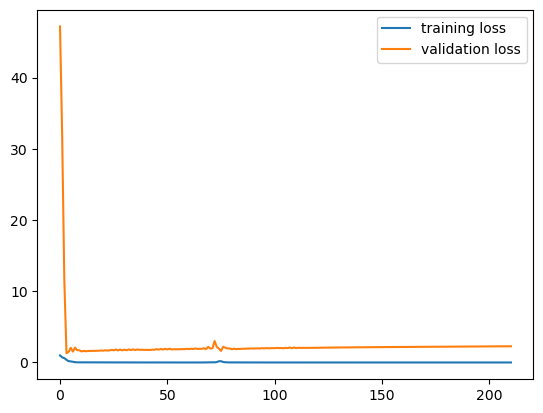

gh2ax
4926


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0098 loss_val: 6.3491 time: 8.9090s
 Epoch: 0010 loss_train: 0.0020 loss_val: 0.6747 time: 7.7241s
 Epoch: 0020 loss_train: 0.0007 loss_val: 0.7037 time: 7.7801s
 Epoch: 0030 loss_train: 0.0004 loss_val: 0.7299 time: 8.4772s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7506 time: 8.0305s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.7680 time: 8.2868s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.7833 time: 7.4702s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.7970 time: 8.1204s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8095 time: 8.7482s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8211 time: 8.7707s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8321 time: 9.4265s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8424 time: 7.8221s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8521 time: 8.6347s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.8615 time: 7.6086s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.8706 time: 7.9873s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.8793 time: 

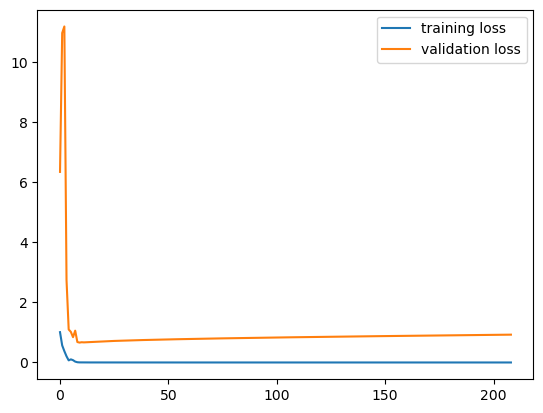

lamin
4927


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9705 loss_val: 22.5609 time: 7.8723s
 Epoch: 0010 loss_train: 0.0034 loss_val: 1.3346 time: 7.6765s
 Epoch: 0020 loss_train: 0.0006 loss_val: 1.3484 time: 6.7945s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.3969 time: 7.9967s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.4341 time: 6.9390s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4650 time: 8.2927s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.4914 time: 8.1401s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.5148 time: 7.9503s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5363 time: 7.8617s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5557 time: 8.5774s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5742 time: 8.5019s
 Epoch: 0110 loss_train: 0.0000 loss_val: 1.5915 time: 8.0880s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.6082 time: 5.9027s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6241 time: 8.2754s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6393 time: 8.0323s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6542 time:

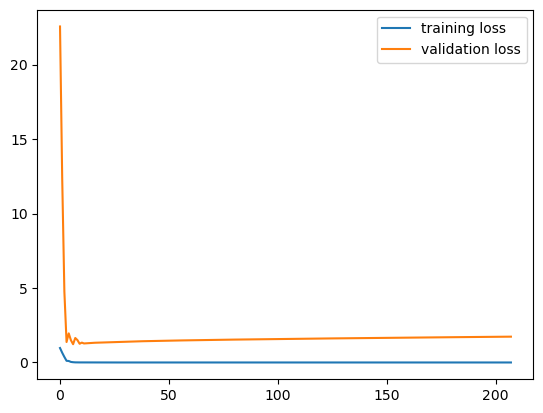

35
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
35
cd16
4608


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1324 loss_val: 1.2224 time: 8.2338s
 Epoch: 0010 loss_train: 0.0189 loss_val: 1.9714 time: 7.1436s
 Epoch: 0020 loss_train: 0.0052 loss_val: 1.9235 time: 7.5752s
 Epoch: 0030 loss_train: 0.0021 loss_val: 1.9812 time: 7.9640s
 Epoch: 0040 loss_train: 0.0017 loss_val: 2.0661 time: 7.5429s
 Epoch: 0050 loss_train: 0.0078 loss_val: 2.2349 time: 6.9144s
 Epoch: 0060 loss_train: 0.0025 loss_val: 2.1307 time: 8.6214s
 Epoch: 0070 loss_train: 0.0012 loss_val: 2.1693 time: 8.0896s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.2115 time: 7.3308s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.2499 time: 7.8339s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.2712 time: 7.3943s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.2901 time: 7.9619s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.3109 time: 7.7523s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.3478 time: 8.0231s
 Epoch: 0140 loss_train: 0.3299 loss_val: 2.3647 time: 7.9069s
 Epoch: 0150 loss_train: 0.0055 loss_val: 2.2660 time: 

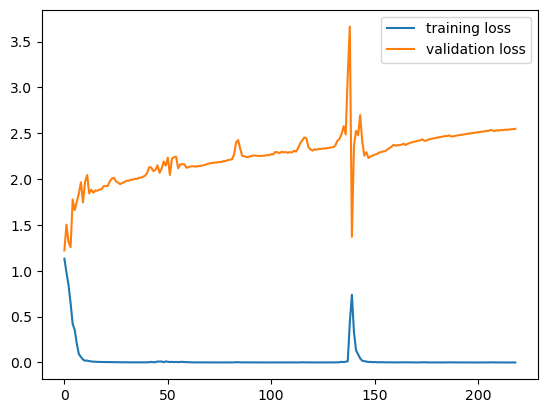

cd3
3822


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0032 loss_val: 1.1191 time: 5.8165s
 Epoch: 0010 loss_train: 0.0048 loss_val: 1.3277 time: 6.3736s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.3210 time: 5.7439s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.3580 time: 6.3151s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3877 time: 6.7313s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4129 time: 6.9157s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4349 time: 6.3566s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4545 time: 7.0944s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4723 time: 6.7246s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4889 time: 6.6093s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5043 time: 6.3590s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5189 time: 6.7740s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5327 time: 6.4801s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5459 time: 5.7682s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5586 time: 6.4609s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5708 time: 

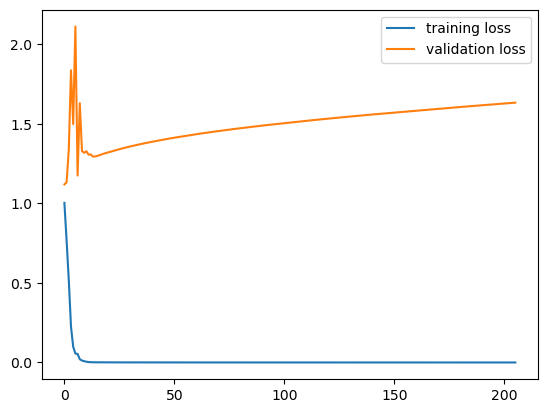

cd4
5637


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1168 loss_val: 24.2434 time: 8.0584s
 Epoch: 0010 loss_train: 0.0231 loss_val: 1.7567 time: 8.4914s
 Epoch: 0020 loss_train: 0.0029 loss_val: 1.7595 time: 8.9404s
 Epoch: 0030 loss_train: 0.0017 loss_val: 1.8142 time: 9.0246s
 Epoch: 0040 loss_train: 0.0009 loss_val: 1.8563 time: 9.0091s
 Epoch: 0050 loss_train: 0.0007 loss_val: 1.8905 time: 9.3241s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.9205 time: 8.2884s
 Epoch: 0070 loss_train: 0.0004 loss_val: 1.9425 time: 9.7485s
 Epoch: 0080 loss_train: 0.0004 loss_val: 1.9707 time: 10.1918s
 Epoch: 0090 loss_train: 0.0004 loss_val: 1.9957 time: 8.0959s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.0201 time: 8.7955s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.0281 time: 8.6362s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.0620 time: 9.4130s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.0803 time: 8.6421s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.0995 time: 9.0506s
 Epoch: 0150 loss_train: 0.0010 loss_val: 2.1002 time

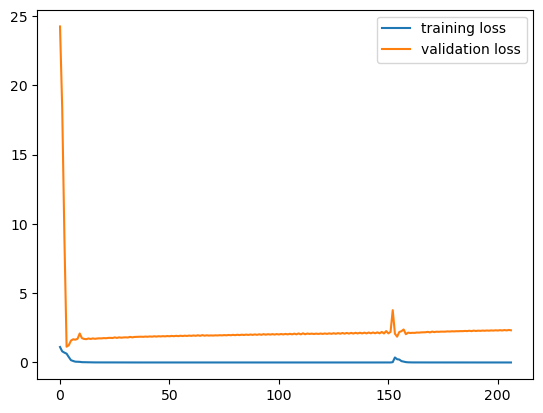

cd8
5659


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9601 loss_val: 46.3149 time: 9.7521s
 Epoch: 0010 loss_train: 0.0098 loss_val: 1.6275 time: 9.6556s
 Epoch: 0020 loss_train: 0.0031 loss_val: 1.7510 time: 9.9658s
 Epoch: 0030 loss_train: 0.0027 loss_val: 1.8150 time: 9.3805s
 Epoch: 0040 loss_train: 0.0061 loss_val: 1.8520 time: 8.4236s
 Epoch: 0050 loss_train: 0.0010 loss_val: 1.8985 time: 10.5862s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.9392 time: 10.5408s
 Epoch: 0070 loss_train: 0.0006 loss_val: 1.9712 time: 8.8965s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.0042 time: 8.7705s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.0364 time: 10.4805s
 Epoch: 0100 loss_train: 0.0364 loss_val: 1.9237 time: 9.3487s
 Epoch: 0110 loss_train: 0.0019 loss_val: 1.9721 time: 10.5068s
 Epoch: 0120 loss_train: 0.0013 loss_val: 2.0236 time: 9.3442s
 Epoch: 0130 loss_train: 0.0024 loss_val: 2.0499 time: 9.2558s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.1133 time: 9.3194s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.1388 t

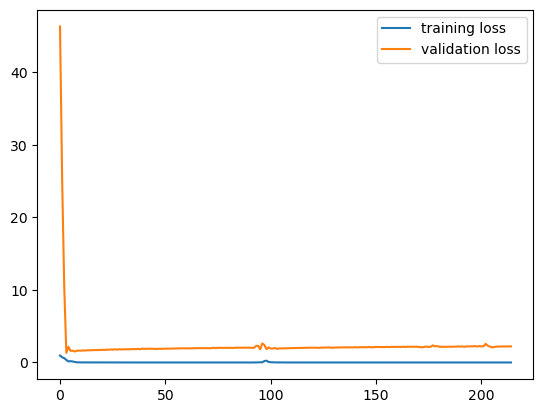

gh2ax
4938


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0186 loss_val: 4.5333 time: 7.8617s
 Epoch: 0010 loss_train: 0.0048 loss_val: 0.8976 time: 8.6938s
 Epoch: 0020 loss_train: 0.0006 loss_val: 0.7586 time: 8.1257s
 Epoch: 0030 loss_train: 0.0003 loss_val: 0.7806 time: 8.4455s
 Epoch: 0040 loss_train: 0.0002 loss_val: 0.7990 time: 7.8022s
 Epoch: 0050 loss_train: 0.0002 loss_val: 0.8150 time: 8.0477s
 Epoch: 0060 loss_train: 0.0001 loss_val: 0.8294 time: 7.9963s
 Epoch: 0070 loss_train: 0.0001 loss_val: 0.8423 time: 8.2427s
 Epoch: 0080 loss_train: 0.0001 loss_val: 0.8543 time: 8.5617s
 Epoch: 0090 loss_train: 0.0001 loss_val: 0.8656 time: 7.1310s
 Epoch: 0100 loss_train: 0.0001 loss_val: 0.8763 time: 7.1322s
 Epoch: 0110 loss_train: 0.0000 loss_val: 0.8865 time: 8.0249s
 Epoch: 0120 loss_train: 0.0000 loss_val: 0.8962 time: 7.2281s
 Epoch: 0130 loss_train: 0.0000 loss_val: 0.9057 time: 9.0148s
 Epoch: 0140 loss_train: 0.0000 loss_val: 0.9149 time: 6.6104s
 Epoch: 0150 loss_train: 0.0000 loss_val: 0.9239 time: 

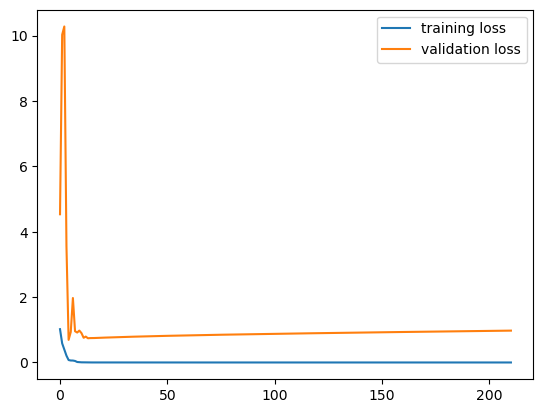

lamin
4939


/tmp/ipykernel_1554704/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554704/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9635 loss_val: 23.1005 time: 7.6736s
 Epoch: 0010 loss_train: 0.0031 loss_val: 1.3078 time: 8.2641s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.4778 time: 8.0322s
 Epoch: 0030 loss_train: 0.0003 loss_val: 1.5057 time: 7.8226s
 Epoch: 0040 loss_train: 0.0002 loss_val: 1.5355 time: 8.0965s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.5620 time: 8.2942s
 Epoch: 0060 loss_train: 0.0001 loss_val: 1.5854 time: 6.9713s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.6067 time: 6.4797s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6263 time: 8.5963s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6444 time: 7.7619s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6618 time: 7.9806s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6783 time: 7.1682s
 Epoch: 0120 loss_train: 0.0000 loss_val: 1.6940 time: 7.7390s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.7093 time: 8.5488s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.7240 time: 8.8638s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7384 time:

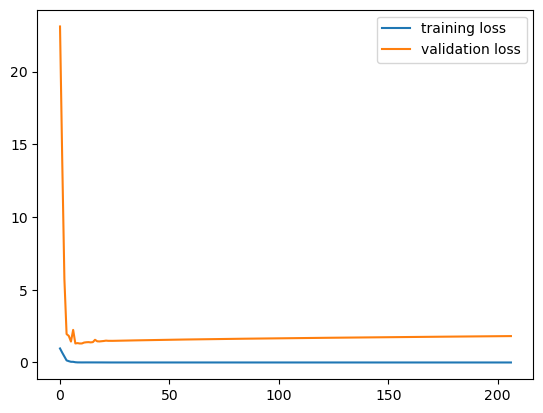

In [9]:
for sample_s in range(prevSampled,nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])
    
    
    print(sample_s)
    nProt=np.unique(proteinNames_samples_s).size
    pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
    plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()
    for p_curr in np.unique(proteinNames_samples_s):

        print(p_curr)
        print(np.sum(proteinNames_samples_s==p_curr))

        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
        model.cuda()
        optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss=[np.inf]*epochs
        val_loss=[np.inf]*epochs

        t_ep=time.time()

        epCounts=0
        for ep in range(epochs):
            train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,imgsP_all_curr,imgsP_all_val_samples_s[p_curr],torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

            if ep>50 and val_loss[ep]>=val_loss[ep-50]:
                epCounts+=1

            if epCounts>150:
                break


            if ep%saveFreq == (saveFreq-1):
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


            model.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))


        with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


        plt.plot(np.arange(epochs),train_loss)
        plt.plot(np.arange(epochs),val_loss)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
        plt.show()


In [10]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

In [12]:
np.unique(proteinNames_samples_s)

array(['cd16', 'cd3', 'cd4', 'cd8', 'gh2ax', 'lamin'], dtype='<U32')

In [11]:
for p_curr in np.unique(proteinNames_samples_s):
    print(p_curr)
    nconditions=np.unique(conditions_all_samples_s[proteinNames_samples_s==p_curr]).size
    res_val=np.zeros((nSamples,nconditions,nconditions))
    correctCount_val=[None]*nSamples
    
    for sample_s in range(nSamples):
        imgsC_all_samples_s=None
        imgsP_all_samples_s=None
        imgNames_all_samples_s=None
        proteinNames_samples_s=None
        pID_all_samples_s=None
        conditions_all_samples_s=None

        imgsC_all_val_samples_s={}
        imgsP_all_val_samples_s={}
        imgNames_all_val_samples_s={}
        proteinTrainInput_val_samples_s={}
        pID_all_val_samples_s={}
        conditions_all_val_samples_s={}
        for condition_i in conditions:
            print(condition_i)
            segDir_i=os.path.join(segDir,condition_i)
            imgDir_i=os.path.join(imgDir,condition_i)
            for stain in os.listdir(segDir_i):
                print(stain)
                segDir_i_stain=os.path.join(segDir_i,stain)
                imgDir_i_stain=os.path.join(imgDir_i,stain)

                segPID2name={}
                for pID_dir in os.listdir(segDir_i_stain):
                    pID=pID_dir.split('_')
                    segPID2name[pID[0]]=pID_dir
                imgPID2name={}
                for pID_dir in os.listdir(imgDir_i_stain):
                    pID=pID_dir.split('_')
                    imgPID2name[pID[0]]=pID_dir
                for pID in segPID2name.keys():
                    if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                        continue
                    if pID in holdOutSamples_samples[sample_s%6]:
                        print('hold out: '+pID)
                        continue
                    print(pID)
                    if pID not in imgPID2name:
                        print('img not found '+pID)
                        continue
                    imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                    segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                    with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                        imgNames=pickle.load(output)
                    with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                        img=pickle.load(output)

                    imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                    proteinNames_curr=np.array([])
                    stain_list=stain.split('_')
                    nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                    np.random.seed(sample_s+6)
                    allIdx_all=np.arange(img.shape[0])
                    np.random.shuffle(allIdx_all)
                    for s in range(1,len(stain_list)):
                        s_start=(s-1)*nImgPerStain
                        if s==len(stain_list)-1:
                            s_end=img.shape[0]
                        else:
                            s_end=s*nImgPerStain
                        imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                        proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                        #store other channels for validation
                        for sother in range(1,len(stain_list)):
                            if sother==s:
                                continue
                            if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                                pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                                imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                                imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                            else:
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                                pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                                imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                                imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                    if pID_all_samples_s is None:
                        pID_all_samples_s=np.repeat(pID,img.shape[0])
                        imgsC_all_samples_s=img[allIdx_all,[0]]
                        imgNames_all_samples_s=imgNames[allIdx_all]
                        proteinNames_samples_s=proteinNames_curr
                        imgsP_all_samples_s=imgP
                        conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                    else:
                        pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                        imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                        imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                        proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                        imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                        conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
        imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])


        print(sample_s)
        nProt=np.unique(proteinNames_samples_s).size
        pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
        plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

        plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)
        
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

        model.cuda()

        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
            val_loss=pickle.load(output)
        minlossepoch=np.argmin(val_loss)
        minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
            if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                minlossepoch_saved=minlossepoch_saved+saveFreq
            else:
                minlossepoch_saved=minlossepoch_saved-saveFreq
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

        #validation samples
        with torch.no_grad():
            model.eval()
            loss_val_all=0
            valIdx=np.arange(revIdx_c_val.size)
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            pred_curr=np.array([])
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                val_labels=torch.tensor(revIdx_c_val[valIdx_i]).cuda().long()
                valInput=torch.tensor(imgsP_all_val_samples_s[p_curr][valIdx_i]).cuda().float()


                pred = model(valInput)

                loss=loss_clf(pred, val_labels)
                loss_val_all+=loss.item()
                pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))

            loss_val_all=loss_val_all/nvalBatches

        print('loss_val: {:.4f}'.format(loss_val_all))
        correctCount=np.sum(pred_curr==revIdx_c_val)/pred_curr.size
        print('acc: {:.4f}'.format(correctCount))

        pred_curr=pred_curr.astype(int)
        res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr],plotsavepath_train_curr,'confusion_val_moreSamples',False,addname='',ctorder=None,vmin=0,vmax=1)
        with open(os.path.join(plotsavepath_train_curr,'pred_val_moreSamples'), 'wb') as output:
            pickle.dump(pred_curr, output, pickle.HIGHEST_PROTOCOL)
        correctCount_val[sample_s]=correctCount

        
    print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
    with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
        pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
        pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)
    




cd16
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
0
loss_val: 2.0522
acc: 0.4503
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd

hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
13
loss_val: 2.0338
acc: 0.4546
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
im

P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
loss_val: 2.1066
acc: 0.4192
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
loss_val: 2.0116
ac

P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
3
loss_val: 1.3393
acc: 0.6166
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
4
loss_val: 1.3937
acc: 0.6097
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
d

HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
17
loss_val: 1.3770
acc: 0.6096
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
gliom

P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
loss_val: 1.4789
acc: 0.6158
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold

P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
9
loss_val: 1.9323
acc: 0.5336
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63

controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
22
loss_val: 2.0841
acc: 0.4844
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P4

HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
35
loss_val: 1.9077
acc: 0.4875
avg val acc: 0.4940
cd8
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P5

P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
12
loss_val: 1.8834
acc: 0.5304
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16


P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
loss_val: 1.8966
acc: 0.5079
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
loss_val: 1.9456
acc: 0.4935
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3

P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
2
loss_val: 0.7940
acc: 0.7813
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
3
loss_val: 0.8293
acc: 0.7758
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd

dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
15
loss_val: 0.8106
acc: 0.7793
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
16
loss_val: 0.8192
acc: 0.7848
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P2

HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
29
loss_val: 0.8195
acc: 0.7791
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
gliom

P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
6
loss_val: 1.2843
acc: 0.6636
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold 

P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
loss_val: 1.5815
acc: 0.6277
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
loss_val: 1.3751
acc: 0.6434
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3

dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
loss_val: 1.4327
acc: 0.6404
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
34
loss_val: 1.4622
acc: 0.6404
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P2